# EveryBeam MWA integration tests

Goes without saying, but the test here rely on `everybeam` being installed. First import some code, and up some observational parameters. 

In [1]:
import sys
##This is to get hold of EveryBeam on my machine
sys.path.append('/home/jline/software/installed/lib/python3.12/site-packages')
import os
from subprocess import call
from astropy.io import fits
import numpy as np
from astropy.table import Column, Table
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy import units as u
import matplotlib.pyplot as plt
import numpy.testing as npt
from astropy.constants import c
from astropy.wcs import WCS
import everybeam as eb
from wodenpy.primary_beam.use_everybeam import load_MWA_telescope, load_OSKAR_telescope, load_LOFAR_telescope, run_everybeam, radec_to_xyz, run_everybeam_over_threads
import erfa
import mwa_hyperbeam
from wodenpy.skymodel.read_fits_skymodel import calc_everybeam_for_components
from wodenpy.use_libwoden.create_woden_struct_classes import Woden_Struct_Classes
from ctypes import c_double
from astropy.time import TimeDelta
from wodenpy.array_layout.precession import RTS_Precess_LST_Lat_to_J2000

import sys
sys.path.append('../../scripts/')
from run_woden import main as run_woden

##A bunch of test and plotting code lives here so we can use it in multile notebooks
from eb_testing_code import create_WCS, plot_jones_on_sky, plot_everybeam_on_sky, make_sky_models, read_uvfits, convert_inst_to_stokes, test_stokes_recovery, getFDF, findpeaks, test_RM_recovery, make_RM_skymodel

os.environ["MWA_BEAM_FILE"] = "/home/jline/software/MWA_beam_files/mwa_full_embedded_element_pattern.h5"

C = c.to('m/s').value

# ra0 = 0.0
# dec0 = -26.7
MWA_LAT=-26.703319405555554
MWA_LONG=116.67081523611111

##pick a time/date that sticks our phase centre overhead
date = "2024-07-21T20:13:00"
##Assume that the OSKAR telescope is near the MWA??
mwa_location = EarthLocation(lat=MWA_LAT*u.deg, 
                            lon=MWA_LONG*u.deg,
                            height=377.827)
observing_time = Time(date, scale='utc', location=mwa_location)

##Grab the LST
LST = observing_time.sidereal_time('mean')
LST_deg = LST.value*15
# print(f"LST: {LST_deg} deg, RA: {ra0}")

## What does the beam look like on the sky?

First up, let's plot the `hyperbeam` `MWA_FEE` beam model on the sky to see what we're expecting. `WODEN` likes the beam to be in IAU ordering, where the first (often called `x`) polarisation is aligned north-south. We also want this the have parallactic rotation, so switch that one. We'll use `hyperbeam` first, which we already use and have tested extensively within `WODEN`.

Note that we precess the array and LST back to J2000; this is how `WODEN` works internally to make everything happen in the J2000 frame. I'm doing it here explicitly to check the beam works in J2000.

/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:18110: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)


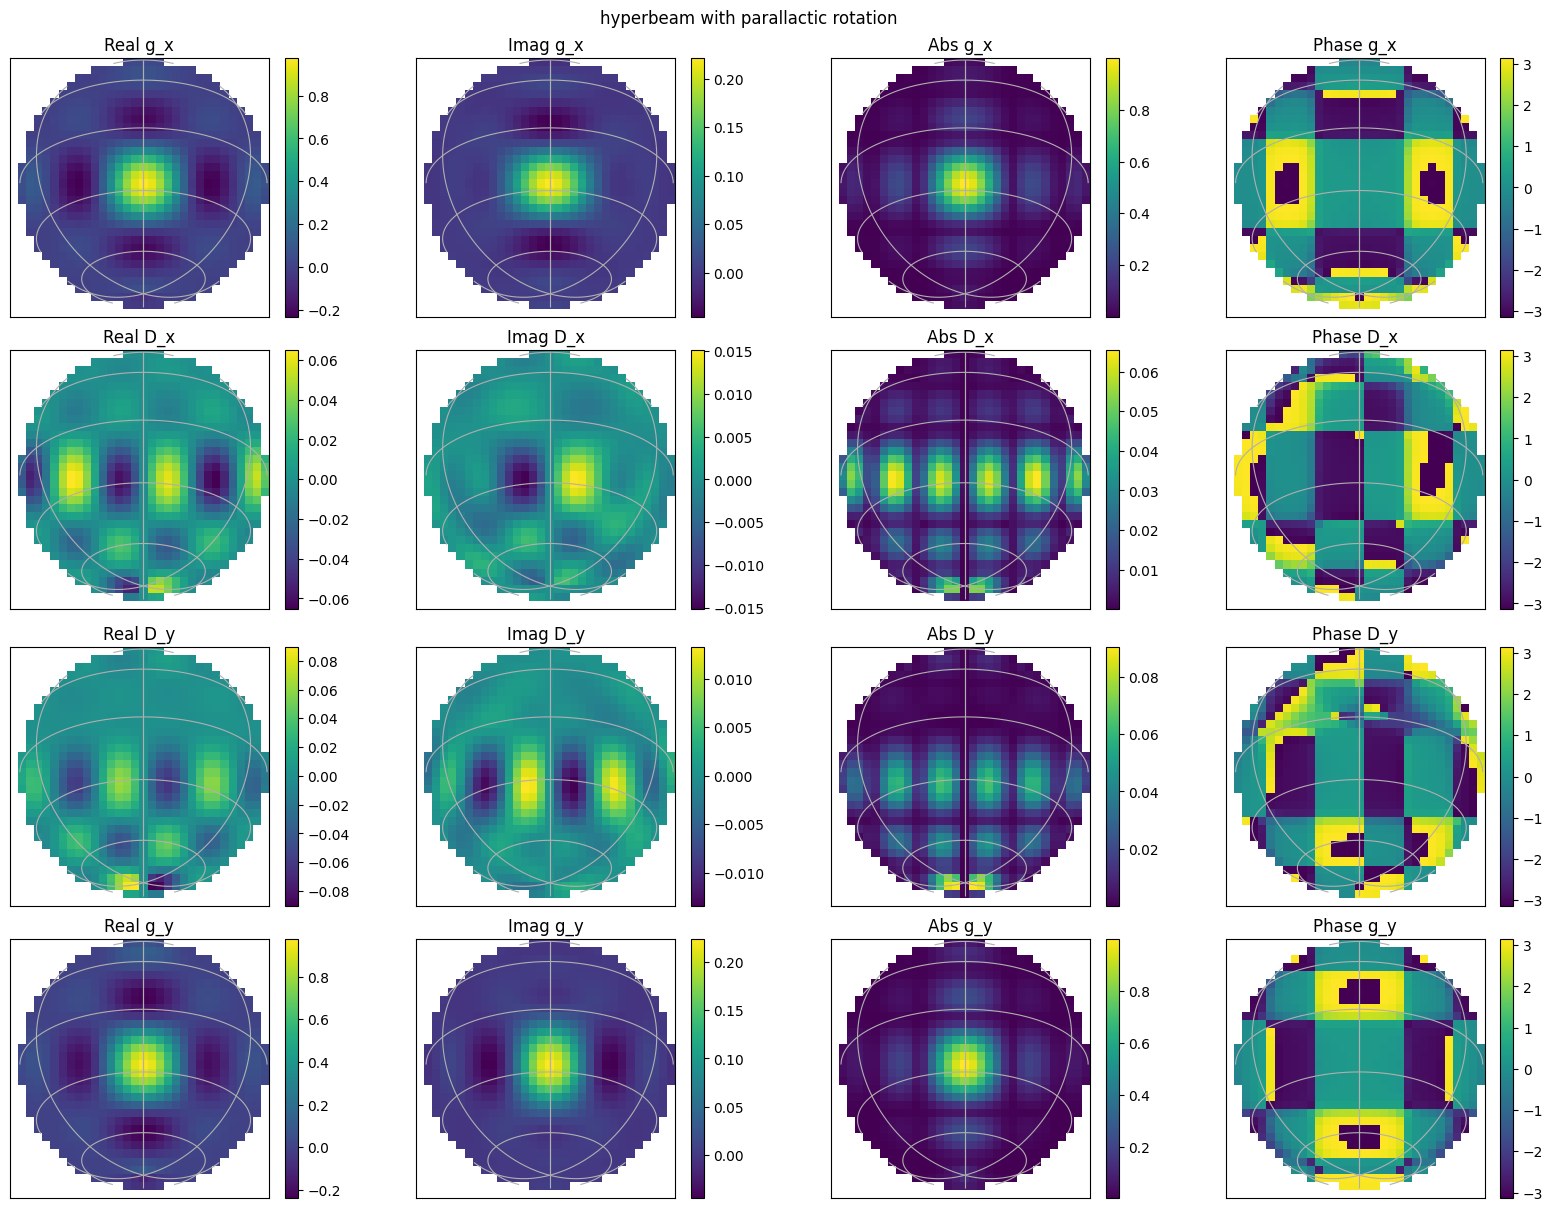

In [2]:
##Set up a grid of RA, Dec points

ra0 = LST_deg
dec0 = MWA_LAT

mjd_current = observing_time.mjd


lst_J2000, latitude_J2000 = RTS_Precess_LST_Lat_to_J2000(np.radians(LST_deg),
                                                         np.radians(MWA_LAT),
                                                         mjd_current)


nside=32
radec_reso=120/nside

header, wcs = create_WCS(ra0, dec0, nside, radec_reso)
x_mesh, y_mesh = np.meshgrid(np.arange(nside), np.arange(nside))
ras, decs = wcs.all_pix2world(x_mesh, y_mesh, 0)

ras = np.radians(ras.flatten())
decs = np.radians(decs.flatten())

##Then use erfa to convert these values into azs, els
# has = np.radians(LST_deg) - ras
has = lst_J2000 - ras

##use this erfa function to convert to azimuth and elevation
##were using degrees, but erfa uses rads, so convert here
az_grid, els = erfa.hd2ae(has, decs, latitude_J2000)
za_grid = np.pi/2 - els

##mwa hyperbeam
beam = mwa_hyperbeam.FEEBeam()

freq = 180e+6

parallactic_rotation = True
IAU_order = True

jones = beam.calc_jones_array(az_grid, za_grid, freq, [0]*16, [1]*16,
                              IAU_order, latitude_J2000, parallactic_rotation)

all_gx_hyp = jones[:,0]
all_Dx_hyp = jones[:,1]
all_Dy_hyp = jones[:,2]
all_gy_hyp = jones[:,3]

all_gx_hyp.shape = (nside, nside)
all_Dx_hyp.shape = (nside, nside)
all_Dy_hyp.shape = (nside, nside)
all_gy_hyp.shape = (nside, nside)

plot_jones_on_sky(all_gx_hyp, all_Dx_hyp, all_Dy_hyp, all_gy_hyp, wcs, title="hyperbeam with parallactic rotation")

Do a sanity check that we have polarisations in the order that we want. North dipoles are most sensitive towards the East-West, so if we subtract Y from X, we should see a positive signal towards the East-West, and negative towards the North-South.

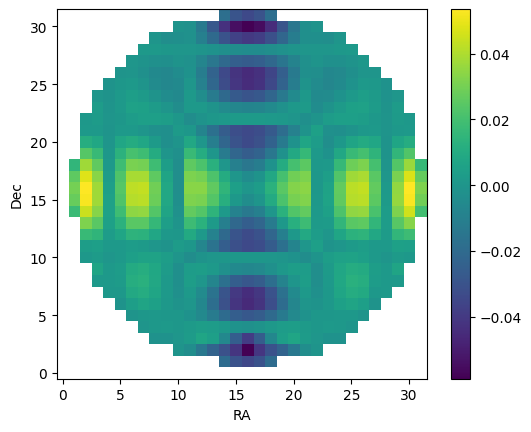

In [3]:
diff = np.abs(all_gx_hyp) - np.abs(all_gy_hyp)
im = plt.imshow(diff, origin='lower')
plt.colorbar(im)
plt.xlabel("RA")
plt.ylabel("Dec")
plt.show()

Aight, cool, we have a sensible beam patter benchmark to compare against.

## EveryBeam MWA
Let's now do the same with `everybeam` `MWA` and see how it compares. We'll use the `wodenpy.use_everybeam.run_everybeam` function to do this, which is what the `wodenpy` sky model reading code uses. However, it's a fairly slow function, so we'll run it in parallel over a number of cores. To do this, we'll use the helper function `wodenpy.use_everybeam.run_everybeam_over_threads`. This uses the same technique that `run_woden.py` uses to parallelise the sky model/beam calculations.

Thread 0 processing coords 0 to 128Thread 5 processing coords 640 to 768Thread 2 processing coords 256 to 384


Thread 6 processing coords 768 to 896Thread 3 processing coords 384 to 512Thread 1 processing coords 128 to 256Thread 7 processing coords 896 to 1024Thread 4 processing coords 512 to 640






/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:18110: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)
/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:18110: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)
/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:18110: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)
/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:18110: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)
/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:18110: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)
/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.

Thread 4 finishedThread 7 finished

Thread 2 finished
Thread 3 finished
Thread 5 finished
Thread 1 finished
Thread 0 finished
Thread 6 finished


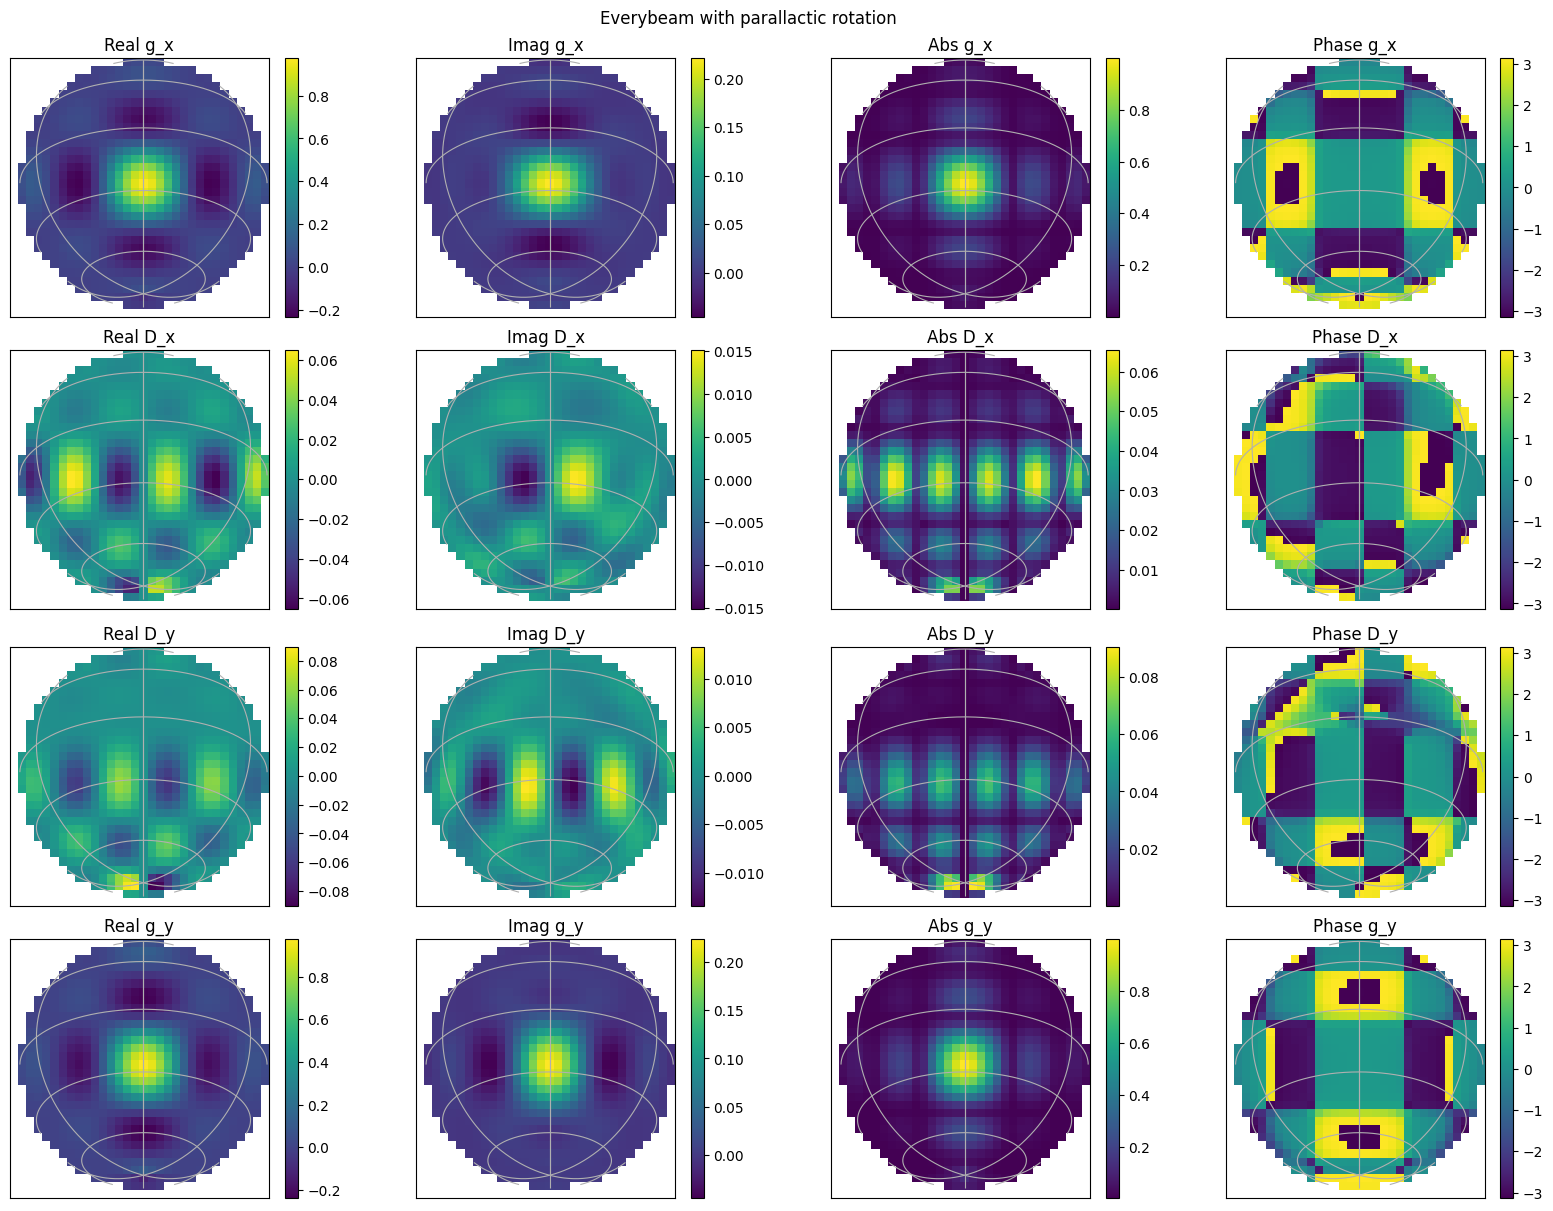

In [4]:
##Example MWA MS from the EveryBeam package
ms_path="MWA-single-timeslot.ms"
coeff_path="/home/jline/software/MWA_beam_files/mwa_full_embedded_element_pattern.h5"
station_id = 0
station_ids = [0]
j2000_latitudes = [latitude_J2000]
j2000_lsts = [lst_J2000]
times = [observing_time]
freqs = [freq]
current_latitude = np.radians(MWA_LAT)
current_longitude = np.radians(MWA_LONG)

##The MWA everybeam model seems to pop out normalised beams
apply_beam_norms=False
use_differential_beam=False

##We need to turn on parallactic rotation in wodenpy as it doesn't exist for
##EveryBeam MWA. We also need to reorder the jones to get north-south first
parallactic_rotate=True
reorder_jones=True

##How many cores to split the work over
num_threads=8

all_jones = run_everybeam_over_threads(num_threads, ms_path,
                            coeff_path,
                            ras, decs,
                            np.radians(ra0), np.radians(dec0),
                            j2000_latitudes, j2000_lsts,
                            current_latitude, current_longitude,
                            times, freqs, station_ids,
                            use_differential_beam=use_differential_beam,
                            apply_beam_norms=apply_beam_norms,
                            reorder_jones=reorder_jones,
                            parallactic_rotate=parallactic_rotate,
                            use_local_mwa=True)

beam_ind, time_ind, freq_ind = 0, 0, 0

all_gx_eb = all_jones[beam_ind, time_ind, freq_ind, :, 0, 0]
all_Dx_eb = all_jones[beam_ind, time_ind, freq_ind, :, 0, 1]
all_Dy_eb = all_jones[beam_ind, time_ind, freq_ind, :, 1, 0]
all_gy_eb = all_jones[beam_ind, time_ind, freq_ind, :, 1, 1]

all_gx_eb.shape = (nside, nside)
all_Dx_eb.shape = (nside, nside)
all_Dy_eb.shape = (nside, nside)
all_gy_eb.shape = (nside, nside)

plot_jones_on_sky(all_gx_eb, all_Dx_eb, all_Dy_eb, all_gy_eb, wcs, 'Everybeam with parallactic rotation')

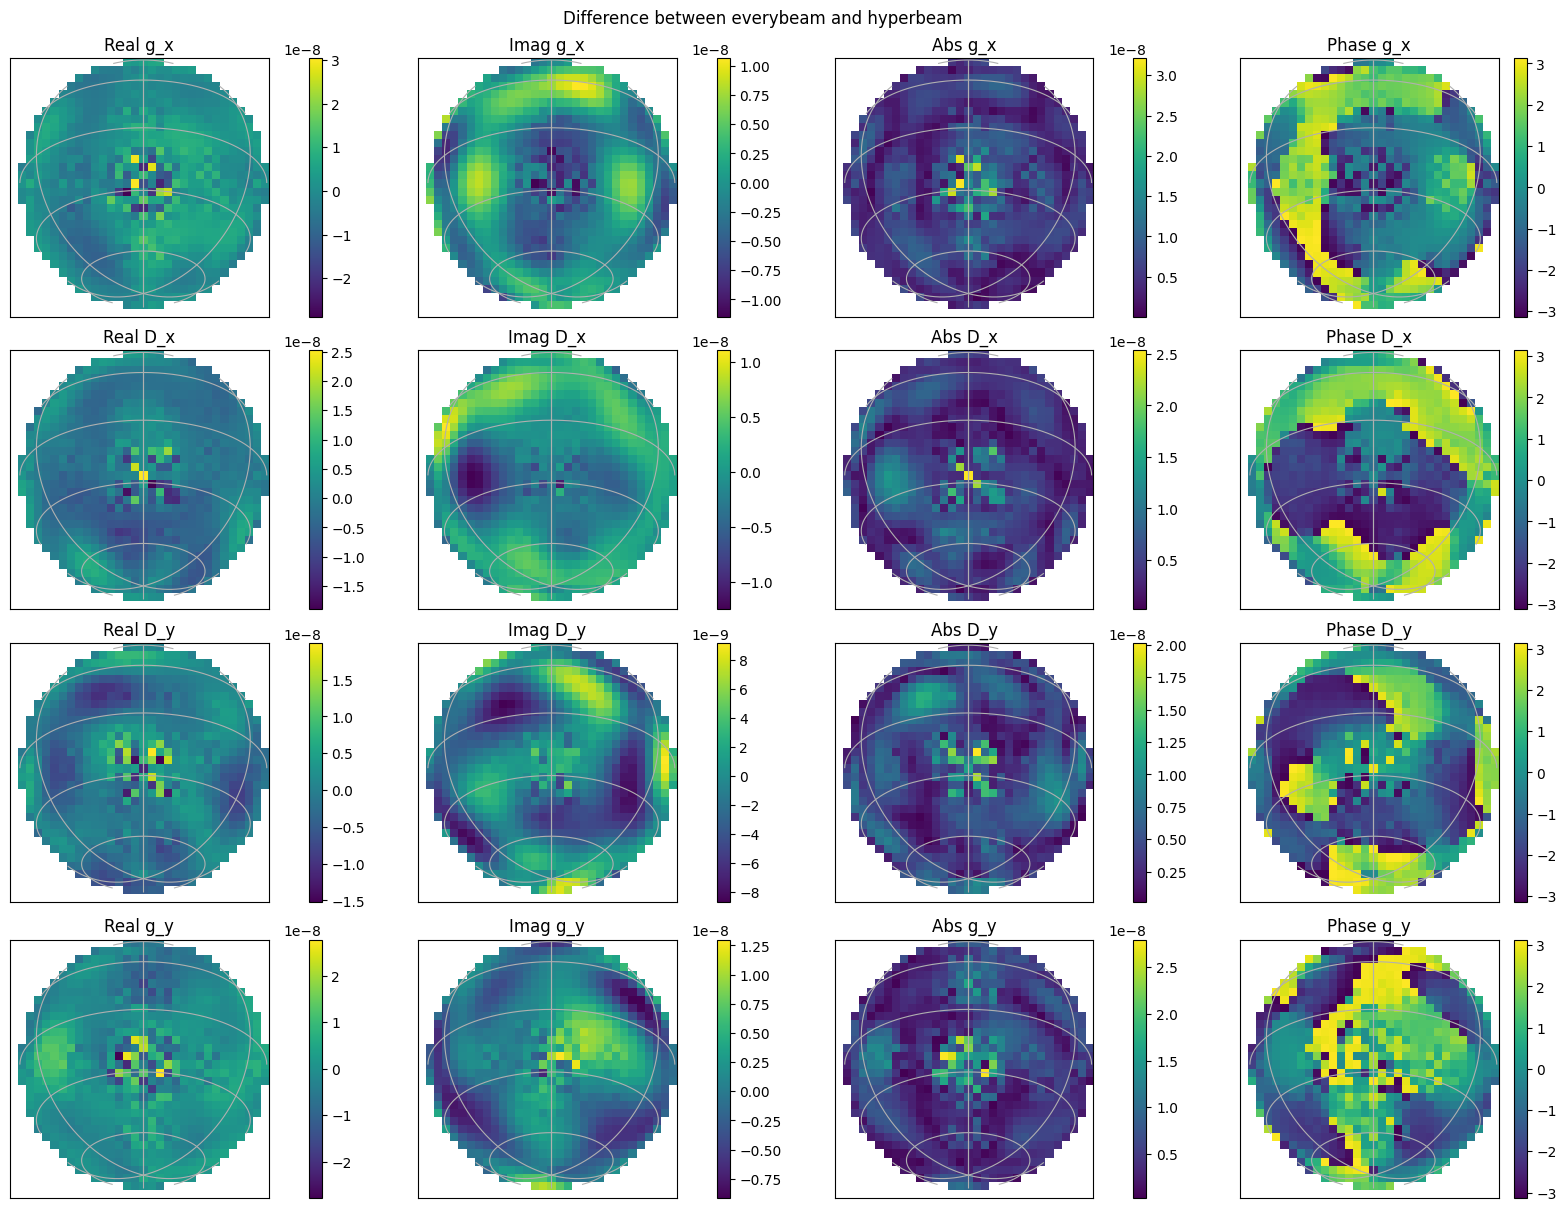

In [5]:
diff_gx = all_gx_eb - all_gx_hyp
diff_Dx = all_Dx_eb - all_Dx_hyp
diff_Dy = all_Dy_eb - all_Dy_hyp
diff_gy = all_gy_eb - all_gy_hyp

plot_jones_on_sky(diff_gx, diff_Dx, diff_Dy, diff_gy, wcs, 'Difference between everybeam and hyperbeam')

Lovely. Things are looking extremely similar, which is great.

## Stokes recovery
Now let's check that we can recover the Stokes parameters from the beam. We'll just test a single point source at zenith, where the gains should essentially be 1.0 and leakage zero. We'll run all Stokes of I, Q, U, V through the full simulator, recombine the linear polarisations, and check we get back what we put in.

First, make our sky models. We'll make 4 Stokes I models, where each has either I, Q, U, V = 1, and all other Stokes are zero. To make that happen for Q/U, make the component a list type so explicitly set one or the other to zero.

In [6]:
make_sky_models(ra0, dec0)

Keep the simulations tiny by making a 3 ant array

In [7]:
np.random.seed(234987)

##make a random array layout. Source is at phase centre, so the visibilities
##should all be full real and just be set by the flux in the sky
num_antennas = 3
east = np.random.uniform(-1000, 1000, num_antennas)
north = np.random.uniform(-1000, 1000, num_antennas)
height = np.zeros(num_antennas)

array = np.empty((num_antennas, 3))
array[:,0] = east
array[:,1] = north
array[:,2] = height

array_name = "eg_array.txt"
np.savetxt(array_name, array)

Run the 4 different Stokes sky models through `hyperbeam` first as a point of comparison. We're avoiding using metafits here to be as apples to apples with `EveryBeam` as possible.


In [8]:
##parameters for the simulation; setting the date sets an LST of about 0 deg
##to match the phase centre

freq_reso = 1e+6
low_freq = 180e+6
high_freq = 210e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)

primary_beam = "MWA_FEE"

for pol in ['I', 'Q', 'U', 'V']:
    
    uvfits_name = f"stokes{pol}_{primary_beam}"
    cat_name = f'{pol}_source.fits'

    args = []

    args.append(f'--ra0={ra0}')
    args.append(f'--dec0={dec0}')
    args.append(f'--array_layout={array_name}')
    args.append(f'--date={date}')
    args.append(f'--output_uvfits_prepend={uvfits_name}')
    args.append(f'--primary_beam={primary_beam}')
    args.append(f'--freq_res={freq_reso}')
    args.append(f'--band_nums=1')
    args.append(f'--num_time_steps=1')
    args.append(f'--IAU_order')
    args.append(f'--cat_filename={cat_name}')
    args.append(f'--lowest_channel_freq={low_freq}')
    args.append(f'--num_freq_channels={num_freq_chans}')
    args.append(f'--time_res=2')
    args.append(f'--MWA_FEE_delays=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]')
    args.append(f'--num_threads=1')

    run_woden(args)

You are using WODEN commit: No git describe nor __version__ avaible
LOADING IN /home/jline/software/WODEN_dev/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00455deg -26.70332deg
Obs epoch initial LST was 0.0087300922 deg
Setting initial J2000 LST to 359.6931723607 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
From Set 0 thread num 0 reading 1 points, 0 gauss, 0 shape, 0 shape coeffs using thread id 0
Finshed thread 0 in 0.0 seconds
Sending set 0 to GPU
Middle freq is 1.80640000e+08 
HIP needs this printf otherwise it doesnt work
Set 0 has returned from the GPU after 0.4 seconds
You are using WODEN commit: No git describe nor __version

Tests are defined in `eb_testing_code.py`, which just asserts that whichever Stokes param we set to one comes out as one, and everything else is zero. Make the absolute tolerance of the test something to toggle, because real beam has leakage, and we don't have the beam at exactly the phase centre for `hyperbeam`. The Stokes recovery is only really legit when the XX and YY beams are the same, so it's good at phase centre and zenith.

Do the actual tests for MWA FEE beam

In [9]:
for pol in ['I', 'Q', 'U', 'V']:
    test_stokes_recovery(pol, 'MWA_FEE', atol=5e-3)


Testing Stokes I
Stokes I passed
Testing Stokes Q
Stokes Q passed
Testing Stokes U
Stokes U passed
Testing Stokes V
Stokes V passed


Right, try and do the same thing with `EveryBeam`

In [10]:
##parameters for the simulation; setting the date sets an LST of about 0 deg
##to match the phase centre

freq_reso = 1e+6
low_freq = 180e+6
high_freq = 210e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)

primary_beam = "everybeam_MWA"

# print("WHAT DIS", os.environ["MWA_FEE_HDF5"])

for pol in ['I', 'Q', 'U', 'V']:

    uvfits_name = f"stokes{pol}_{primary_beam}"
    cat_name = f'{pol}_source.fits'
    
    args = []

    args.append(f'--ra0={ra0}')
    args.append(f'--dec0={dec0}')
    args.append(f'--array_layout={array_name}')
    args.append(f'--date={date}')
    args.append(f'--output_uvfits_prepend={uvfits_name}')
    args.append(f'--primary_beam={primary_beam}')
    args.append(f'--beam_ms_path={ms_path}')
    args.append(f'--freq_res={freq_reso}')
    args.append(f'--band_nums=1')
    args.append(f'--num_time_steps=1')
    args.append(f'--IAU_order')
    args.append(f'--station_id=0')
    args.append(f'--cat_filename={cat_name}')
    args.append(f'--lowest_channel_freq={low_freq}')
    args.append(f'--num_freq_channels={num_freq_chans}')
    args.append(f'--time_res=2')
    args.append(f'--num_threads=1')

    run_woden(args)

You are using WODEN commit: No git describe nor __version__ avaible
LOADING IN /home/jline/software/WODEN_dev/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00455deg -26.70332deg
Obs epoch initial LST was 0.0087300922 deg
Setting initial J2000 LST to 359.6931723607 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
From Set 0 thread num 0 reading 1 points, 0 gauss, 0 shape, 0 shape coeffs using thread id 0
Finshed thread 0 in 2.3 seconds
Sending set 0 to GPU
Set 0 has returned from the GPU after 0.0 seconds
You are using WODEN commit: No git describe nor __version__ avaible
LOADING IN /home/jline/software/WODEN_dev/wodenpy/libwoden_double.s

In [11]:
for pol in ['I', 'Q', 'U', 'V']:
    test_stokes_recovery(pol, 'everybeam_MWA', atol=5e-3)
    
    ##Uncomment to print out example values
    # uvfits_name = f"stokes{pol}_everybeam_MWA"
    # XX, XY, YX, YY = read_uvfits(f'{uvfits_name}_band01.uvfits')
    # ##pick a random baseline to plot, they should all be the sam
    # baseline = 0

    # recover_I, recover_Q, recover_U, recover_V = convert_inst_to_stokes(XX[baseline], XY[baseline], YX[baseline], YY[baseline])
    # print(f"{pol}, {recover_I[0].real:.2f}, {recover_Q[0].real:.2f}, {recover_U[0].real:.2f}, {recover_V[0].real:.2f}")

Testing Stokes I
Stokes I passed
Testing Stokes Q
Stokes Q passed
Testing Stokes U
Stokes U passed
Testing Stokes V
Stokes V passed


## Now test an RM recovery
Check we recover the correct RM and sign for a linearly polarised source. First of all, make the sky model.

In [12]:
phi_RM, pol_frac = make_RM_skymodel(ra0, dec0)

Run that through WODEN using `hyperbeam` to check the test is working.

In [13]:
freq_reso = 0.1e+6
low_freq = 180e+6
high_freq = 210e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)


primary_beam = "MWA_FEE"

uvfits_name = f"rm_source_{primary_beam}"
cat_name = 'RM_source.fits'

args = []

args.append(f'--ra0={ra0}')
args.append(f'--dec0={dec0}')
args.append(f'--array_layout={array_name}')
args.append(f'--date={date}')
args.append(f'--output_uvfits_prepend={uvfits_name}')
args.append(f'--primary_beam={primary_beam}')
args.append(f'--freq_res={freq_reso}')
args.append(f'--band_nums=1')
args.append(f'--num_time_steps=1')
args.append(f'--IAU_order')
args.append(f'--MWA_FEE_delays=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]')
args.append(f'--cat_filename={cat_name}')
args.append(f'--lowest_channel_freq={low_freq}')
args.append(f'--num_freq_channels={num_freq_chans}')
args.append(f'--time_res=2')
args.append(f'--num_threads=1')

run_woden(args)

You are using WODEN commit: No git describe nor __version__ avaible
LOADING IN /home/jline/software/WODEN_dev/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00455deg -26.70332deg
Obs epoch initial LST was 0.0087300922 deg
Setting initial J2000 LST to 359.6931723607 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
From Set 0 thread num 0 reading 1 points, 0 gauss, 0 shape, 0 shape coeffs using thread id 0
Finshed thread 0 in 0.0 seconds
Sending set 0 to GPU
Middle freq is 1.80640000e+08 
HIP needs this printf otherwise it doesnt work
Set 0 has returned from the GPU after 0.1 seconds


Have a look and check our visis make sense

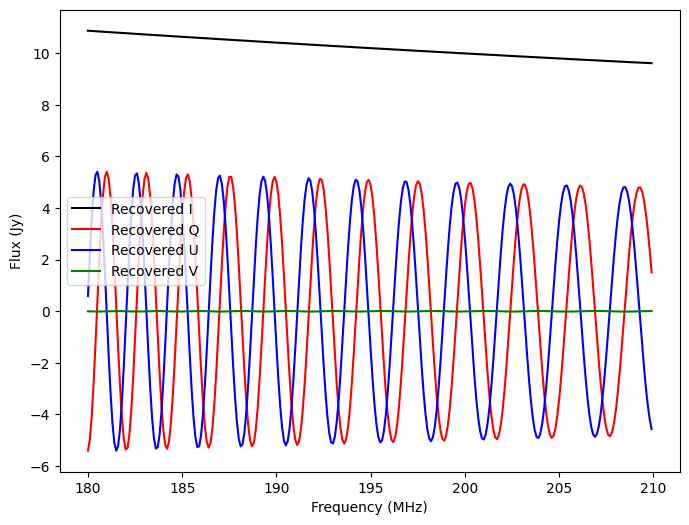

In [14]:
XX, XY, YX, YY = read_uvfits('rm_source_MWA_FEE_band01.uvfits')
baseline = 0    
recover_I, recover_Q, recover_U, recover_V = convert_inst_to_stokes(XX[baseline], XY[baseline], YX[baseline], YY[baseline])

    
freqs = np.arange(low_freq, high_freq, freq_reso)

fig, axs = plt.subplots(1, 1, figsize=(8, 6))

axs.plot(freqs / 1e+6, recover_I.real, 'k-', label='Recovered I')
axs.plot(freqs / 1e+6, recover_Q.real, 'r', label='Recovered Q')
axs.plot(freqs / 1e+6, recover_U.real, 'b', label='Recovered U')
axs.plot(freqs / 1e+6, recover_V.real, 'g', label='Recovered V')

axs.legend()

axs.set_xlabel('Frequency (MHz)')
axs.set_ylabel('Flux (Jy)')

plt.show()

# fig, axs = plt.subplots(1, 1, figsize=(8, 6))
# axs.plot(freqs / 1e+6, recover_I.real, 'k-', label='Polarisation Fraction')

Now define a test, using a bunch of Emil's RM synthesis code. 

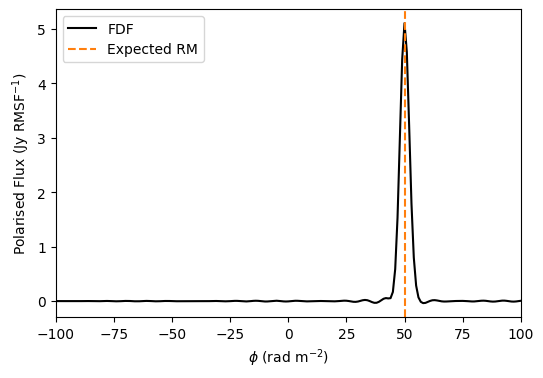

Recovered RM: 50.0 Expected RM: 50
Recovered Pol. Fraction: 0.49999538 Expected Pol Fraction 0.5


In [15]:
test_RM_recovery(uvfits_name, phi_RM, pol_frac, freqs)

Loverly, works a treat. Now let's do that with `EveryBeam`.

In [16]:
freq_reso = 0.1e+6
low_freq = 180e+6
high_freq = 210e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)

primary_beam = "everybeam_MWA"
uvfits_name = f"rm_source_{primary_beam}"
cat_name = 'RM_source.fits'

args = []

args.append(f'--ra0={ra0}')
args.append(f'--dec0={dec0}')
args.append(f'--array_layout={array_name}')
args.append(f'--date={date}')
args.append(f'--output_uvfits_prepend={uvfits_name}')
args.append(f'--primary_beam={primary_beam}')
args.append(f'--beam_ms_path={ms_path}')
args.append(f'--freq_res={freq_reso}')
args.append(f'--band_nums=1')
args.append(f'--num_time_steps=1')
args.append(f'--IAU_order')
args.append(f'--station_id=0')
args.append(f'--cat_filename={cat_name}')
args.append(f'--lowest_channel_freq={low_freq}')
args.append(f'--num_freq_channels={num_freq_chans}')
args.append(f'--time_res=2')
args.append(f'--num_threads=1')

run_woden(args)


You are using WODEN commit: No git describe nor __version__ avaible
LOADING IN /home/jline/software/WODEN_dev/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00455deg -26.70332deg
Obs epoch initial LST was 0.0087300922 deg
Setting initial J2000 LST to 359.6931723607 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
From Set 0 thread num 0 reading 1 points, 0 gauss, 0 shape, 0 shape coeffs using thread id 0
Finshed thread 0 in 24.6 seconds
Sending set 0 to GPU
Set 0 has returned from the GPU after 0.0 seconds


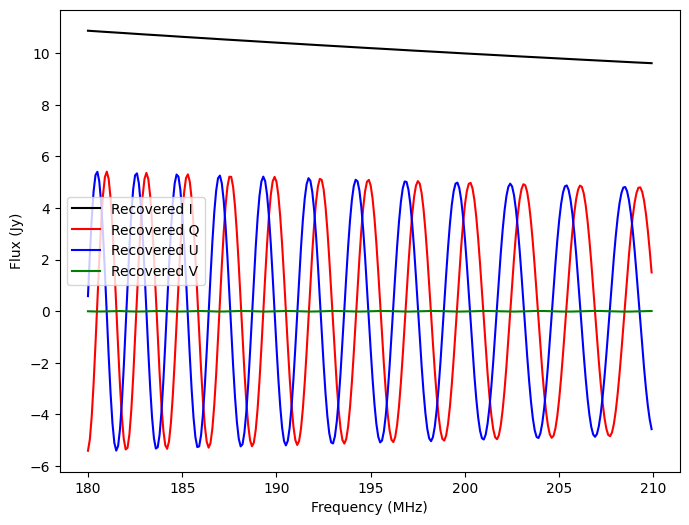

In [17]:
XX, XY, YX, YY = read_uvfits('rm_source_everybeam_MWA_band01.uvfits')
baseline = 0    
recover_I, recover_Q, recover_U, recover_V = convert_inst_to_stokes(XX[baseline], XY[baseline], YX[baseline], YY[baseline])

    
freqs = np.arange(low_freq, high_freq, freq_reso)

fig, axs = plt.subplots(1, 1, figsize=(8, 6))

axs.plot(freqs / 1e+6, recover_I.real, 'k-', label='Recovered I')
axs.plot(freqs / 1e+6, recover_Q.real, 'r', label='Recovered Q')
axs.plot(freqs / 1e+6, recover_U.real, 'b', label='Recovered U')
axs.plot(freqs / 1e+6, recover_V.real, 'g', label='Recovered V')

axs.legend()

axs.set_xlabel('Frequency (MHz)')
axs.set_ylabel('Flux (Jy)')

plt.show()

Looks good!

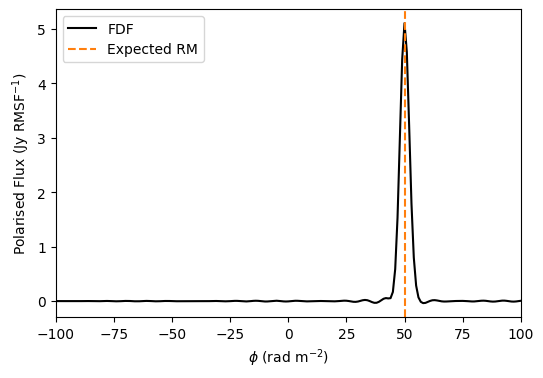

Recovered RM: 50.0 Expected RM: 50
Recovered Pol. Fraction: 0.49999538 Expected Pol Fraction 0.5


In [18]:
test_RM_recovery(uvfits_name, phi_RM, pol_frac, freqs)

Yup works woot

## Test antenna locations

Now check to see if the antenna locations are read in correctly from a measurement set. We'll run `WODEN` using the a `metafits` file first, and then using a measurement set that came out of `hyperdrive` which is calibrated data that matches the observation of the `metafits`. Hopefully they match up.

In [19]:
phi_RM, pol_frac = make_RM_skymodel(ra0, dec0)
ra0 = 60.0
date = "2015-09-10T19:44:15"

freq_reso = 0.1e+6
low_freq = 180e+6
num_freq_chans = 1

primary_beam = "MWA_FEE"

uvfits_name = f"ant_locs_{primary_beam}"
cat_name = 'RM_source.fits'

args = []

args.append(f'--ra0={ra0}')
args.append(f'--dec0={dec0}')
args.append(f'--date={date}')
args.append(f'--output_uvfits_prepend={uvfits_name}')
args.append(f'--metafits_filename=../../examples/metafits/1125949472_metafits.fits')
args.append(f'--primary_beam={primary_beam}')
args.append(f'--freq_res={freq_reso}')
args.append(f'--band_nums=1')
args.append(f'--num_time_steps=1')
args.append(f'--IAU_order')
args.append(f'--cat_filename={cat_name}')
args.append(f'--lowest_channel_freq={low_freq}')
args.append(f'--num_freq_channels={num_freq_chans}')
args.append(f'--time_res=2')
args.append(f'--MWA_FEE_delays=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]')
args.append(f'--num_threads=1')

run_woden(args)

You are using WODEN commit: No git describe nor __version__ avaible
LOADING IN /home/jline/software/WODEN_dev/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 60.00000deg -26.70332deg
Obs epoch initial LST was 42.2620215148 deg
Setting initial J2000 LST to 42.0911874758 deg
Setting initial mjd to 57275.8224074073
After precession initial latitude of the array is -26.7665041369 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
From Set 0 thread num 0 reading 1 points, 0 gauss, 0 shape, 0 shape coeffs using thread id 0
Finshed thread 0 in 0.0 seconds
Sending set 0 to GPU
Middle freq is 1.80640000e+08 
HIP needs this printf otherwise it doesnt work
Set 0 has returned from the GPU after 0.0 seconds


In [20]:
primary_beam = "everybeam_MWA"

uvfits_name = f"ant_locs_{primary_beam}"
cat_name = 'RM_source.fits'

ms_path = '/mnt/c/Users/jackl/Dropbox/work/test_WODEN/everybeam/run_MWA_beam/hypcal_1125949472.ms'


args = []

args.append(f'--ra0={ra0}')
args.append(f'--dec0={dec0}')
args.append(f'--date={date}')
args.append(f'--output_uvfits_prepend={uvfits_name}')
args.append(f'--primary_beam={primary_beam}')
args.append(f'--beam_ms_path={ms_path}')
args.append(f'--freq_res={freq_reso}')
args.append(f'--band_nums=1')
args.append(f'--num_time_steps=1')
args.append(f'--IAU_order')
args.append(f'--station_id=0')
args.append(f'--cat_filename={cat_name}')
args.append(f'--lowest_channel_freq={low_freq}')
args.append(f'--num_freq_channels={num_freq_chans}')
args.append(f'--time_res=2')

run_woden(args)

Successful readonly open of default-locked table /mnt/c/Users/jackl/Dropbox/work/test_WODEN/everybeam/run_MWA_beam/hypcal_1125949472.ms/ANTENNA: 13 columns, 128 rows
You are using WODEN commit: No git describe nor __version__ avaible
LOADING IN /home/jline/software/WODEN_dev/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 60.00000deg -26.70332deg
Obs epoch initial LST was 42.2620215148 deg
Setting initial J2000 LST to 42.0911874758 deg
Setting initial mjd to 57275.8224074073
After precession initial latitude of the array is -26.7665041369 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
From Set 0 thread num 0 reading 1 points, 0 gauss, 0 shape, 0 shape coeffs using thread id 0From Set 0 thread num 1 reading 0 points, 0 gauss, 0 shape, 0 shape coef

Read in the XYZ positions from the resultant `uvfits` files, as well as the `uvw` coordinates.

In [21]:
def read_xyz_uvfits(uvfits_name):
    
    with fits.open(uvfits_name) as hdu:
        xyz = hdu[1].data['STABXYZ']
        uu = hdu[0].data['UU']*C
        vv = hdu[0].data['VV']*C
        ww = hdu[0].data['WW']*C
        
    return xyz, uu, vv, ww


In [22]:
xyz_meta, uu_meta, vv_meta, ww_meta = read_xyz_uvfits('ant_locs_MWA_FEE_band01.uvfits')
xyz_ms, uu_ms, vv_ms, ww_ms = read_xyz_uvfits('ant_locs_everybeam_MWA_band01.uvfits')

First up compare the XYZ coords

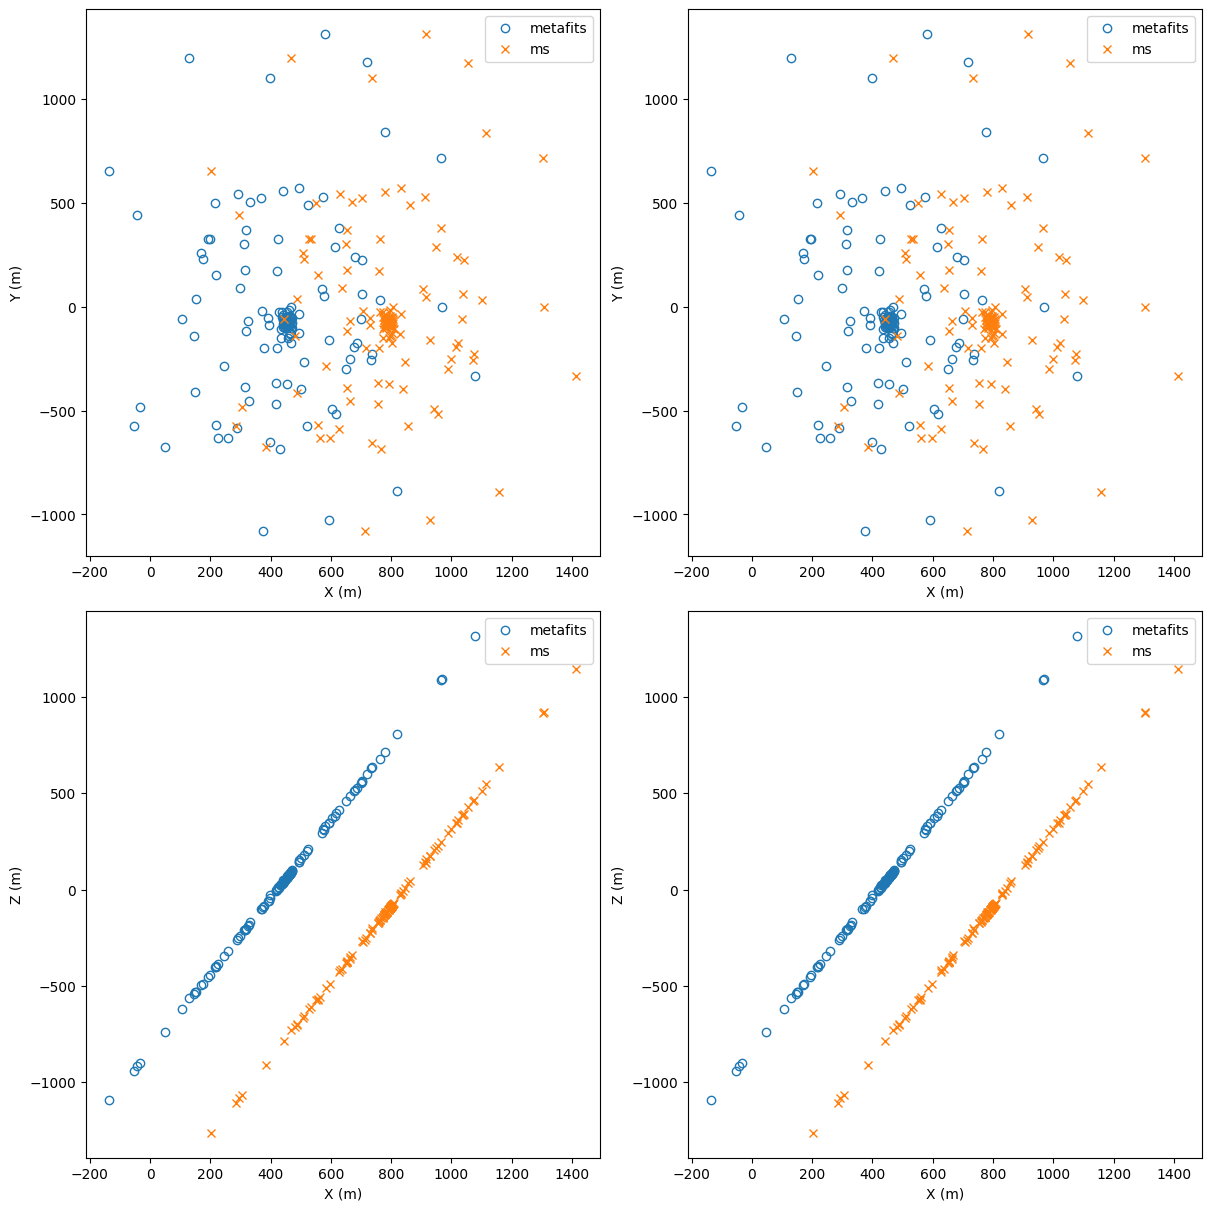

In [23]:
def plot(xyz, ax1, ax2, marker, label):
        
        ax1.plot(xyz[:,0], xyz[:,1], marker, mfc='none', label=label)
        ax2.plot(xyz[:,0], xyz[:,2], marker, mfc='none', label=label)
        
        
fig, axs = plt.subplots(2, 2, figsize=(12, 12), layout='constrained')

plot(xyz_meta, axs[0,0], axs[1,0], 'o', 'metafits')
plot(xyz_ms, axs[0,0], axs[1,0], 'x', 'ms')

plot(xyz_meta, axs[0,1], axs[1,1], 'o', 'metafits')
plot(xyz_ms, axs[0,1], axs[1,1], 'x', 'ms')

for ax in axs.flatten():
    ax.legend()
    
axs[0,0].set_xlabel('X (m)')
axs[0,0].set_ylabel('Y (m)')
axs[0,1].set_xlabel('X (m)')
axs[0,1].set_ylabel('Y (m)')

axs[1,0].set_xlabel('X (m)')
axs[1,0].set_ylabel('Z (m)')
axs[1,1].set_xlabel('X (m)')
axs[1,1].set_ylabel('Z (m)')

plt.show()

Ah bummer there is some kind of central positional shift in the XYZs. It is unclear if this is a `WODEN` or a `hyperdrive` issue. The layouts are exactly the same, just offset.

In [24]:
np.allclose(xyz_meta, xyz_ms, atol=1e-3, rtol=1e-6)


False

Now compare the `uv` coords. 

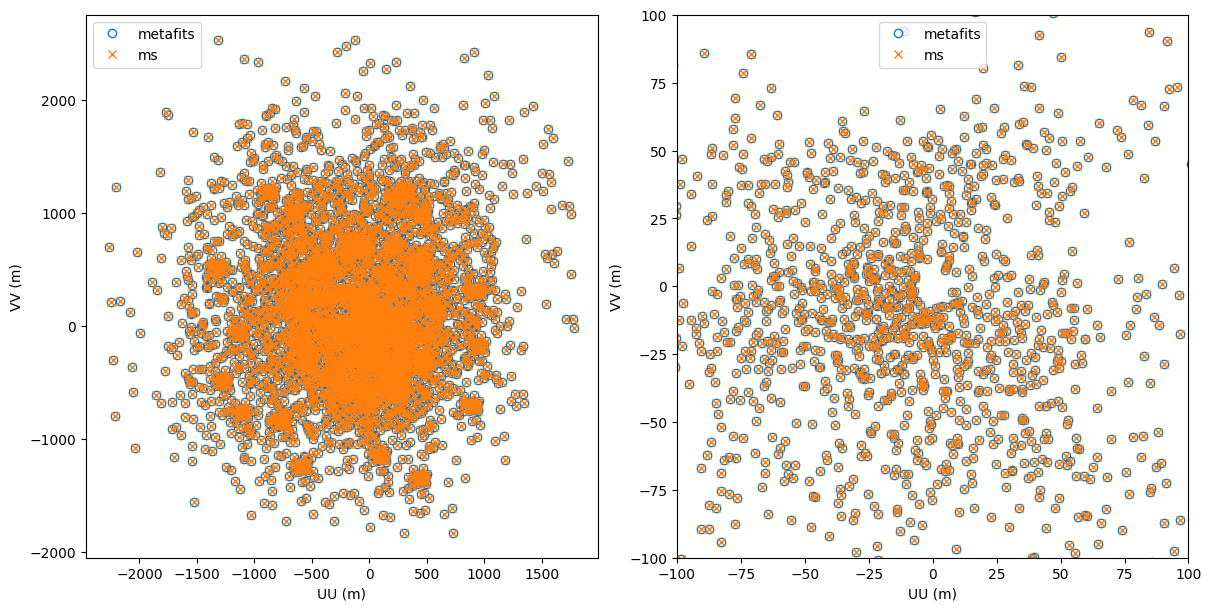

In [25]:
        
fig, axs = plt.subplots(1, 2, figsize=(12, 6), layout='constrained')


for ax in axs:

    ax.plot(uu_meta, vv_meta, 'C0o', mfc='none', label='metafits')
    # ax.plot(-uu_meta, -vv_meta, 'C0o', mfc='none')

    ax.plot(uu_ms, vv_ms, 'C1x', mfc='none', label='ms')
    # ax.plot(-uu_ms, -vv_ms, 'C1x', mfc='none')
    
    ax.set_xlabel('UU (m)')
    ax.set_ylabel('VV (m)')
    
    ax.legend()
        
axs[1].set_xlim(-100, 100)
axs[1].set_ylim(-100, 100)

plt.show()

In [26]:
print(f"u coords max, mean diff {np.max(np.abs(uu_meta - uu_ms)):.2e}, {np.mean(np.abs(uu_meta - uu_ms)):.2e} (metres)")
print(f"v coords max, mean diff {np.max(np.abs(vv_meta - vv_ms)):.2e}, {np.mean(np.abs(vv_meta - vv_ms)):.2e} (metres)")
print(f"w coords max, mean diff {np.max(np.abs(ww_meta - ww_ms)):.2e}, {np.mean(np.abs(ww_meta - ww_ms)):.2e} (metres)")

u coords max, mean diff 8.79e-03, 3.11e-04 (metres)
v coords max, mean diff 8.01e-03, 2.91e-04 (metres)
w coords max, mean diff 2.32e-03, 9.60e-05 (metres)


The layout might be shifted, but the layout is pretty much indentical, as we end up with the same `uv` coordinates. So that's good.

## Test source positions
With the array offset seen, we need to check that the source positions are still coming out correctly. Make a simulation with a grid of sources, and check that the source positions are coming out correctly.

In [27]:
nside=5
half_width = 5

ra0 = 60.0
dec0 = -30.0

ras = np.linspace(ra0 - half_width, ra0 + half_width, nside)
decs = np.linspace(dec0 - half_width, dec0 + half_width, nside)

ras, decs = np.meshgrid(ras, decs)
ras, decs = ras.flatten(), decs.flatten()

num_comps = len(ras)

ras = ras.flatten()
decs = decs.flatten()

c_ids = Column(data=np.array(['source']*num_comps), name='UNQ_SOURCE_ID', dtype='|S20')
c_names = Column(data=np.array([f'source_C{i:04d}' for i in range(num_comps)]), name='NAME', dtype='|S20')

##Component position
c_ras = Column(data=ras, name='RA')
c_decs = Column(data=decs, name='DEC')

##This says we have a point source
c_comp_types = Column(data=np.array(['P']*num_comps, dtype='|S1'), name="COMP_TYPE", dtype='|S1')
##This says we have a Stokes I power-law SED
c_mod_types = Column(data=np.array(['pl']*num_comps, dtype='|S3'), name="MOD_TYPE", dtype='|S3')

##Set everything as a flat spectrum 1 Jy stokes I source. That way we can image it and see the beam pattern
c_stokes_I_ref = Column(data=np.ones(num_comps), name='NORM_COMP_PL')
c_stokes_I_SI = Column(data=np.zeros(num_comps), name='ALPHA_PL')


cols = [c_ids, c_names, c_ras, c_decs, c_comp_types, c_mod_types, c_stokes_I_ref, c_stokes_I_SI]

main_table = Table(cols)

cat_name = 'check_positions.fits'

main_table.write(cat_name, format='fits', overwrite=True)

In [28]:
primary_beam = "everybeam_MWA"

uvfits_name = f"check_positions_{primary_beam}"
cat_name = 'check_positions.fits'

ms_path = '/mnt/c/Users/jackl/Dropbox/work/test_WODEN/everybeam/run_MWA_beam/hypcal_1125949472.ms'

num_freq_chans = 10
freq_reso = 100e+3
low_freq = 150e+6

ra0 = 60.0
dec0 = -30.0

args = []

args.append(f'--ra0={ra0}')
args.append(f'--dec0={dec0}')
args.append(f'--metafits_filename=1125949472_metafits.fits')
args.append(f'--output_uvfits_prepend={uvfits_name}')
args.append(f'--primary_beam={primary_beam}')
args.append(f'--beam_ms_path={ms_path}')
args.append(f'--freq_res={freq_reso}')
args.append(f'--band_nums=1')
args.append(f'--num_time_steps=5')
args.append(f'--IAU_order')
args.append(f'--station_id=0')
args.append(f'--cat_filename={cat_name}')
args.append(f'--lowest_channel_freq={low_freq}')
args.append(f'--num_freq_channels={num_freq_chans}')
args.append(f'--time_res=2')

run_woden(args)

Successful readonly open of default-locked table /mnt/c/Users/jackl/Dropbox/work/test_WODEN/everybeam/run_MWA_beam/hypcal_1125949472.ms/ANTENNA: 13 columns, 128 rows
You are using WODEN commit: No git describe nor __version__ avaible
LOADING IN /home/jline/software/WODEN_dev/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 60.00000deg -30.00000deg
Obs epoch initial LST was 42.2620215148 deg
Setting initial J2000 LST to 42.0911874758 deg
Setting initial mjd to 57275.8224074073
After precession initial latitude of the array is -26.7665041369 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 25 components
After cropping there are 25 components
From Set 0 thread num 0 reading 4 points, 0 gauss, 0 shape, 0 shape coeffs using thread id 0From Set 0 thread num 2 reading 4 points, 0 gauss, 0 shape, 0 shape co

In [29]:
cmd = "woden_uv2ms.py "
cmd += "  --uvfits_prepend=check_positions_everybeam_MWA_band "
cmd += "  --band_nums=1  "

call(cmd, shell=True)

cmd = "wsclean -name check_positions_everybeam_MWA -size 2048 2048 -niter 2000 "
cmd += "  -auto-threshold 0.5 -auto-mask 3 "
cmd += "  -pol I -multiscale -weight briggs 0 -scale 0.01 -j 12 -mgain 0.85 "
cmd += "  -no-update-model-required "
cmd += "  check_positions_everybeam_MWA_band*.ms "

##something is cooked with my local wsclean installation, so I have to call
##this on the command line, hence just printing here
print(cmd)
# call(cmd, shell=True)

/home/jline/software/anaconda3/envs/woden_dev/bin/woden_uv2ms.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.3.0')
The telescope frame is set to '????', which generally indicates ignorance. Defaulting the frame to 'itrs', but this may lead to other warnings or errors.
Writing in the MS file that the units of the data are uncalib, although some CASA process will ignore this and assume the units are all in Jy (or may not know how to handle data in these units).


wsclean -name check_positions_everybeam_MWA -size 2048 2048 -niter 2000   -auto-threshold 0.5 -auto-mask 3   -pol I -multiscale -weight briggs 0 -scale 0.01 -j 12 -mgain 0.85   -no-update-model-required   check_positions_everybeam_MWA_band*.ms 


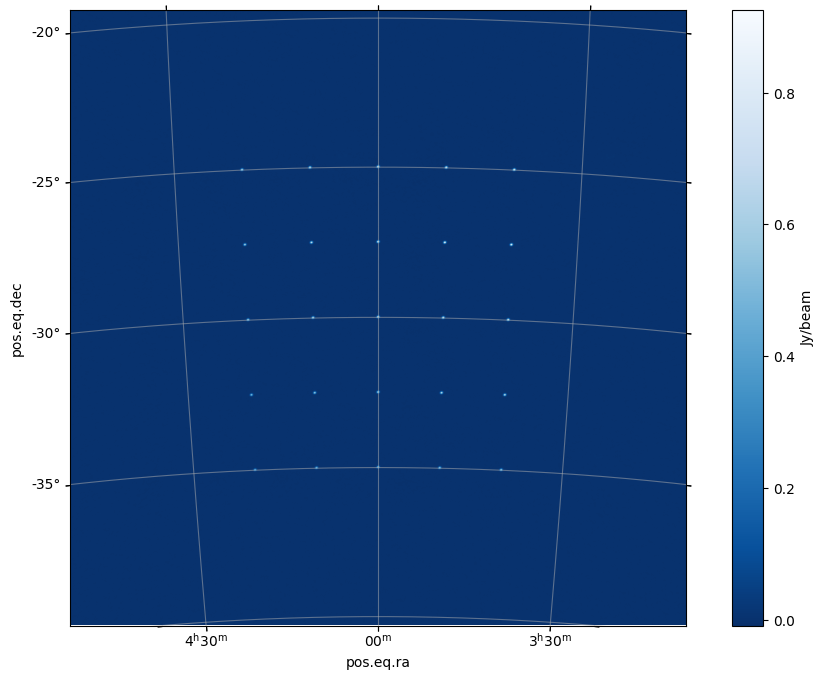

In [30]:
with fits.open('check_positions_everybeam_MWA-image.fits') as hdu:
    image = np.squeeze(hdu[0].data)
    wcs = WCS(hdu[0].header).celestial
    
fig, axs = plt.subplots(1, 1, figsize=(12, 8), subplot_kw={'projection': wcs})

im = axs.imshow(image, origin='lower', cmap='Blues_r')#, vmin=0, vmax=1.0)
plt.colorbar(im, ax=axs, label='Jy/beam')

# half_width = 600

# axs.set_xlim(1024-half_width, 1024+half_width)
# axs.set_ylim(1024-half_width, 1024+half_width)

plt.grid(alpha=0.5)

plt.show()

Everything seems to be in the correct RA/Dec position, so that's schweet.

## Try off zenith pointings
Now we'll test whether we can do off-zenith pointings. We'll also test that we can run multiple time steps and frequencies. The measurement set I'm using is real calibrated data from the MWA. Unfortunately, it's 2GB, so there's no good way to include that with the `WODEN` repo. If you want to run this test, you should be able to get some data from the MWA ASVO https://asvo.mwatelescope.org/, and then convert that into a measurement set using `pyuvdata` for example.

In [31]:

ra0 = 60.0
dec0 = -30.0
date = "2015-09-10T19:44:15"
observing_time = Time(date, scale='utc', location=mwa_location)

##Setup a grid of RA/Dec on the sky
nside=50
radec_reso = 120/nside

header, wcs = create_WCS(ra0, dec0, nside, radec_reso)
x_mesh, y_mesh = np.meshgrid(np.arange(nside), np.arange(nside))
ras, decs = wcs.all_pix2world(x_mesh, y_mesh, 0)

ras = np.radians(ras.flatten())
decs = np.radians(decs.flatten())

num_comps = len(ras)

##Do a single freqs and time and beam
all_freqs = np.array([100e+6, 200e+6])
all_times = np.array([observing_time, observing_time + TimeDelta(2*3600.0, format='sec')])
num_beams = 1
station_ids = [0]

lsts = []
latitudes = []

for obs_time in all_times:
    
    LST = obs_time.sidereal_time('mean')
    lst_current = np.radians(LST.value*15)
    
    lst_J2000, latitude_J2000 = RTS_Precess_LST_Lat_to_J2000(
                                lst_current,
                                np.radians(MWA_LAT),
                                obs_time.mjd)
    
    lsts.append(lst_J2000)
    latitudes.append(latitude_J2000)

coeff_path="/home/jline/software/MWA_beam_files/mwa_full_embedded_element_pattern.h5"
ms_path = '/mnt/c/Users/jackl/Dropbox/work/test_WODEN/everybeam/run_MWA_beam/hypcal_1125949472.ms'

use_differential_beam=False
apply_beam_norms = False
reorder_jones = True
parallactic_rotate = True

num_threads = 8

all_jones = run_everybeam_over_threads(num_threads, ms_path,
                            coeff_path,
                            ras, decs,
                            np.radians(ra0), np.radians(dec0),
                            latitudes, lsts,
                            np.radians(MWA_LAT), np.radians(MWA_LONG),
                            all_times, all_freqs, station_ids,
                            use_differential_beam=use_differential_beam,
                            apply_beam_norms=apply_beam_norms,
                            reorder_jones=reorder_jones,
                            parallactic_rotate=parallactic_rotate)

Thread 0 processing coords 0 to 313Thread 3 processing coords 939 to 1252Thread 4 processing coords 1252 to 1565Thread 6 processing coords 1878 to 2191Thread 1 processing coords 313 to 626Thread 2 processing coords 626 to 939Thread 5 processing coords 1565 to 1878








/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:18110: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)
/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:18110: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)
/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:18110: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)
/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:18110: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)
/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:18110: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)
/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.

Thread 7 processing coords 2191 to 2504


/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:18110: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)


Thread 7 finished
Thread 2 finished
Thread 3 finished
Thread 5 finished
Thread 6 finished
Thread 0 finished
Thread 4 finished
Thread 1 finished


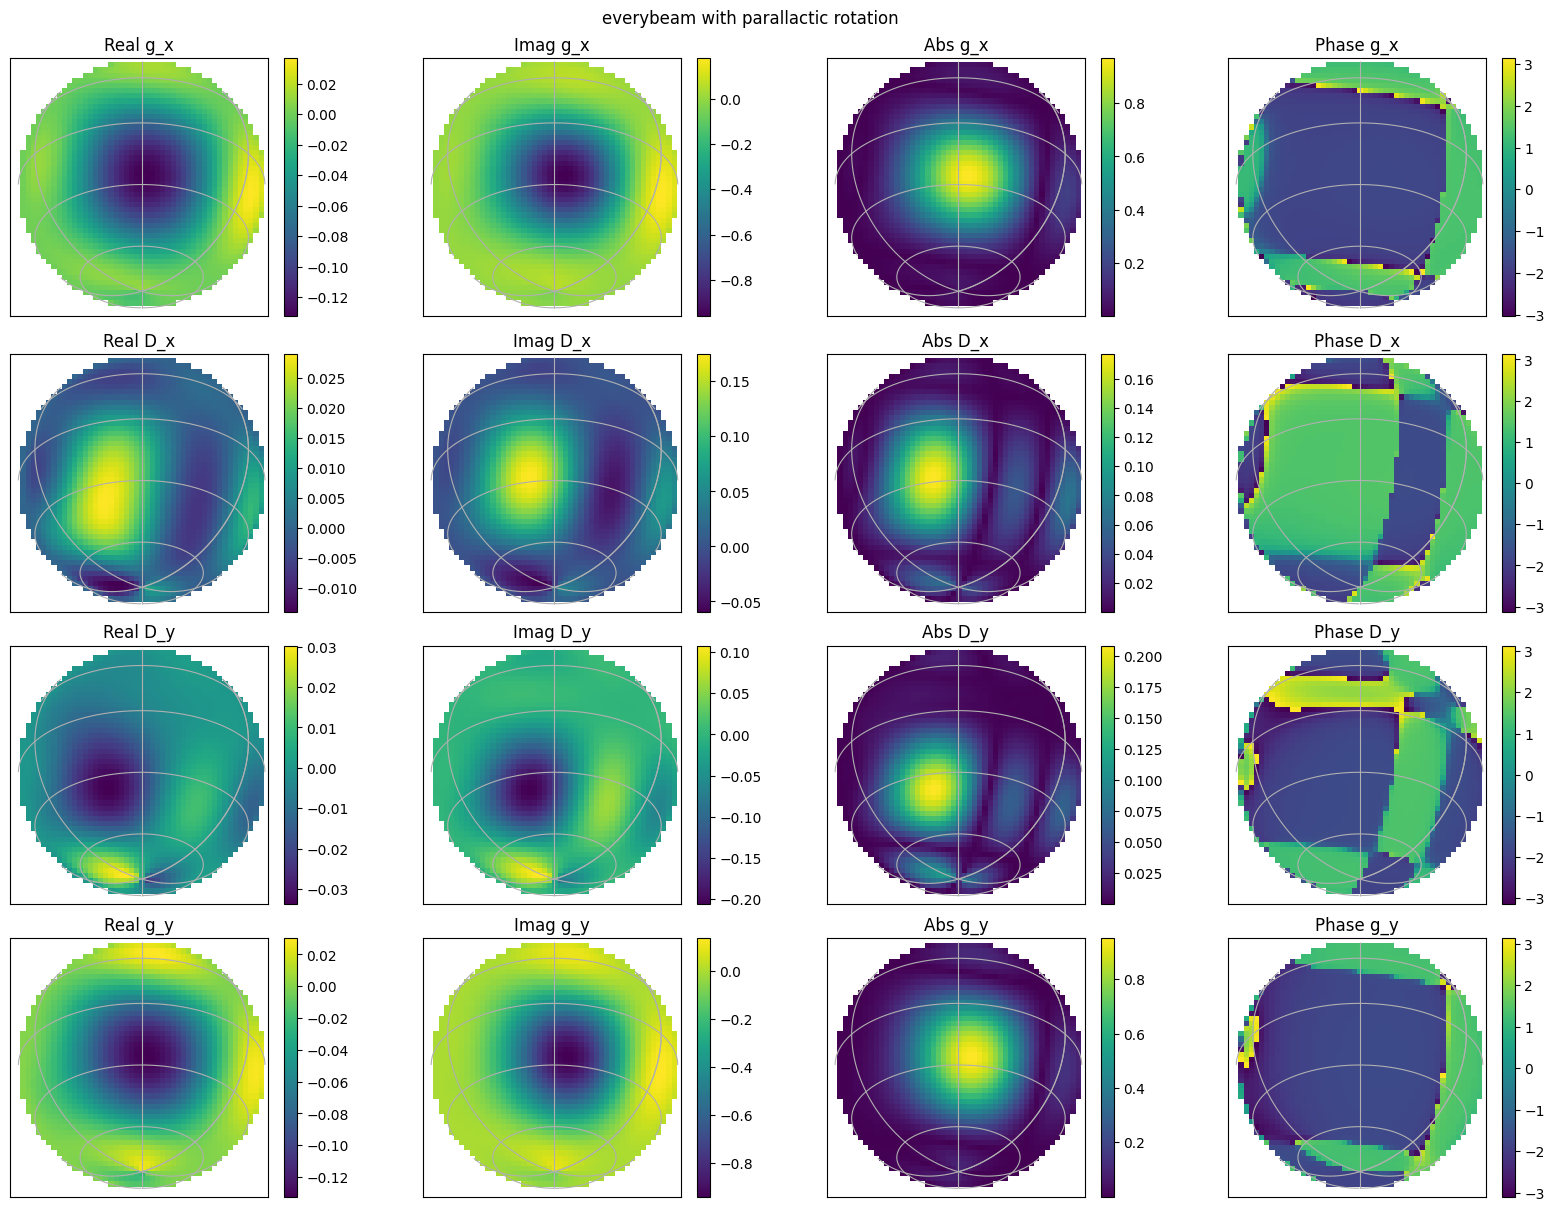

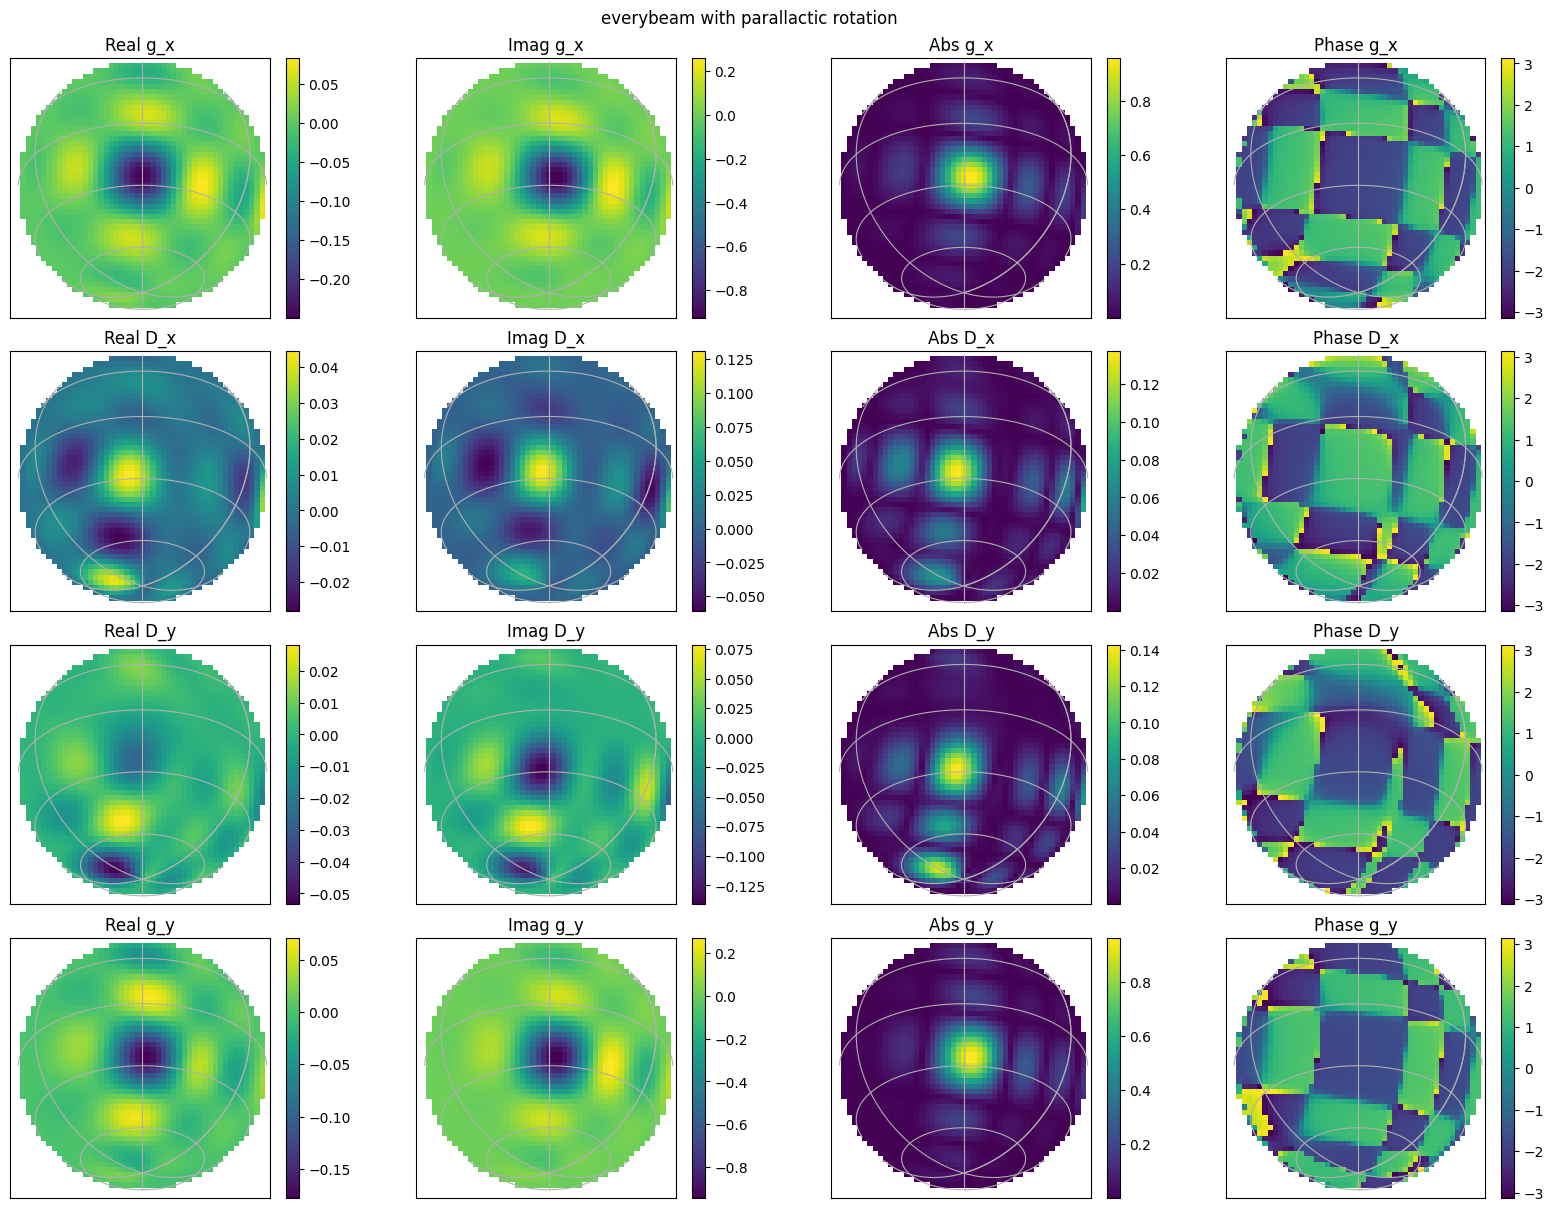

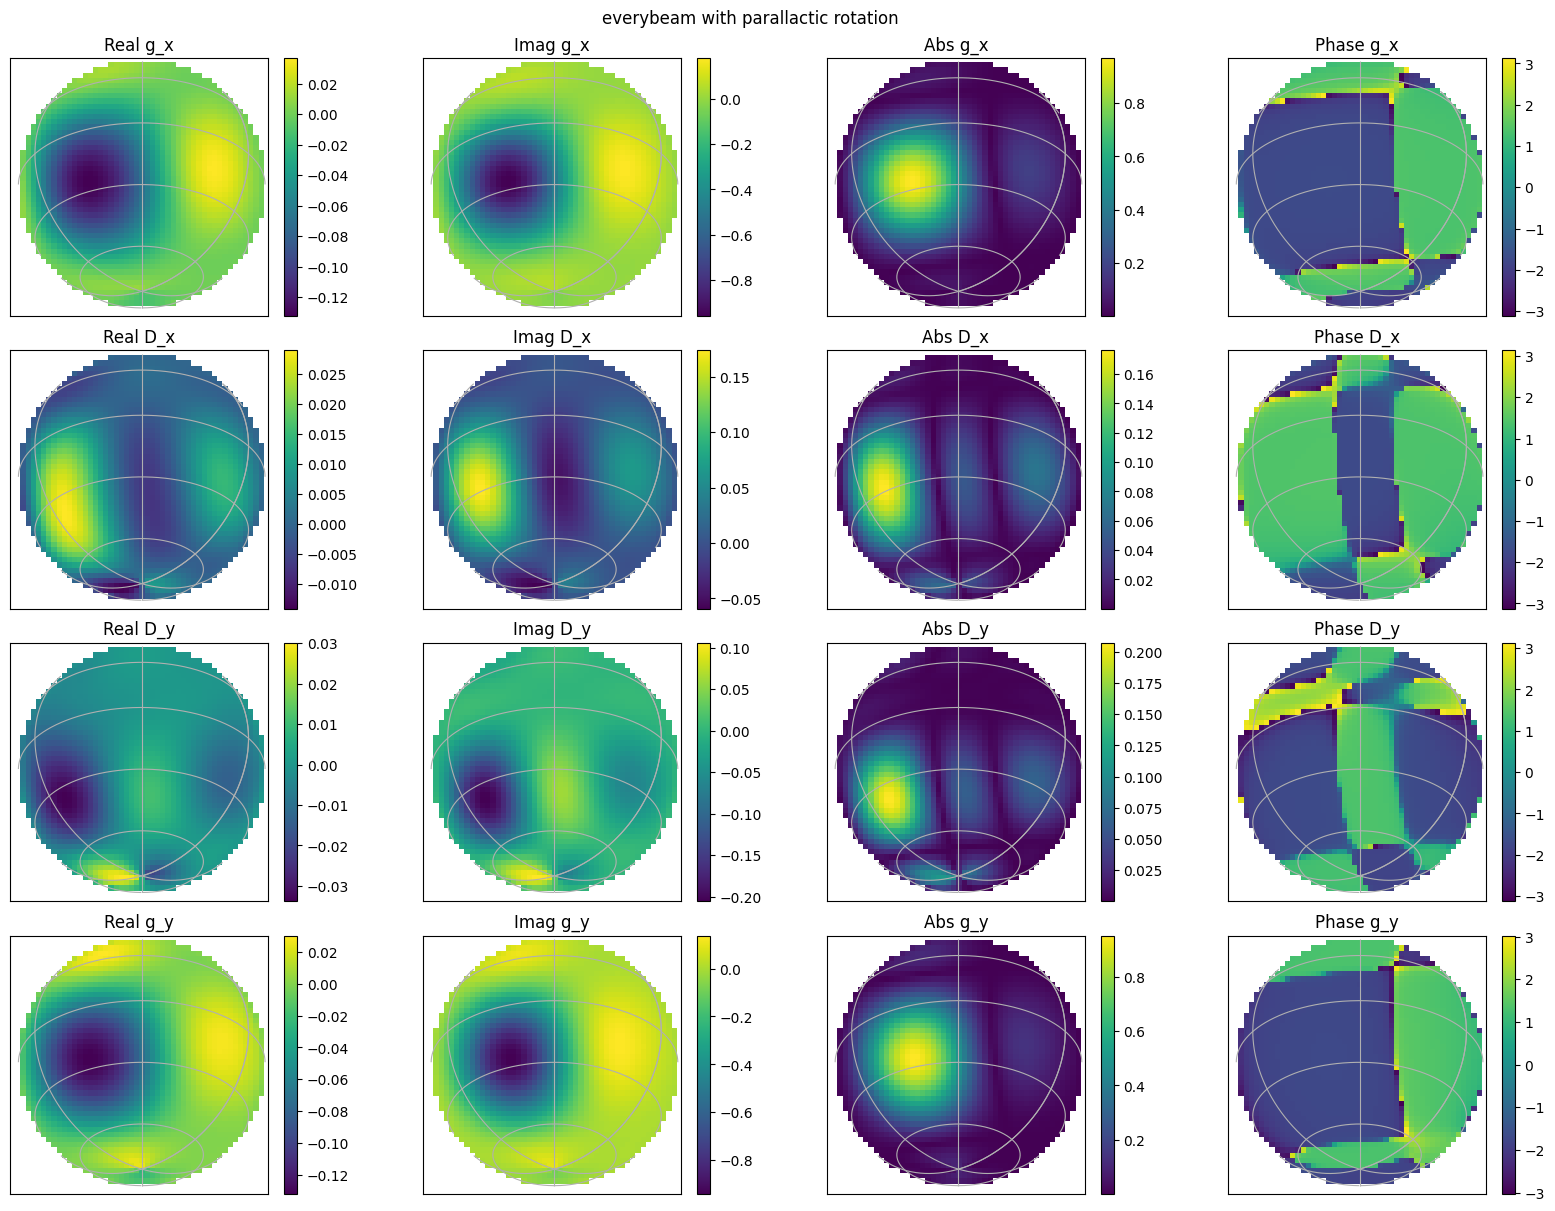

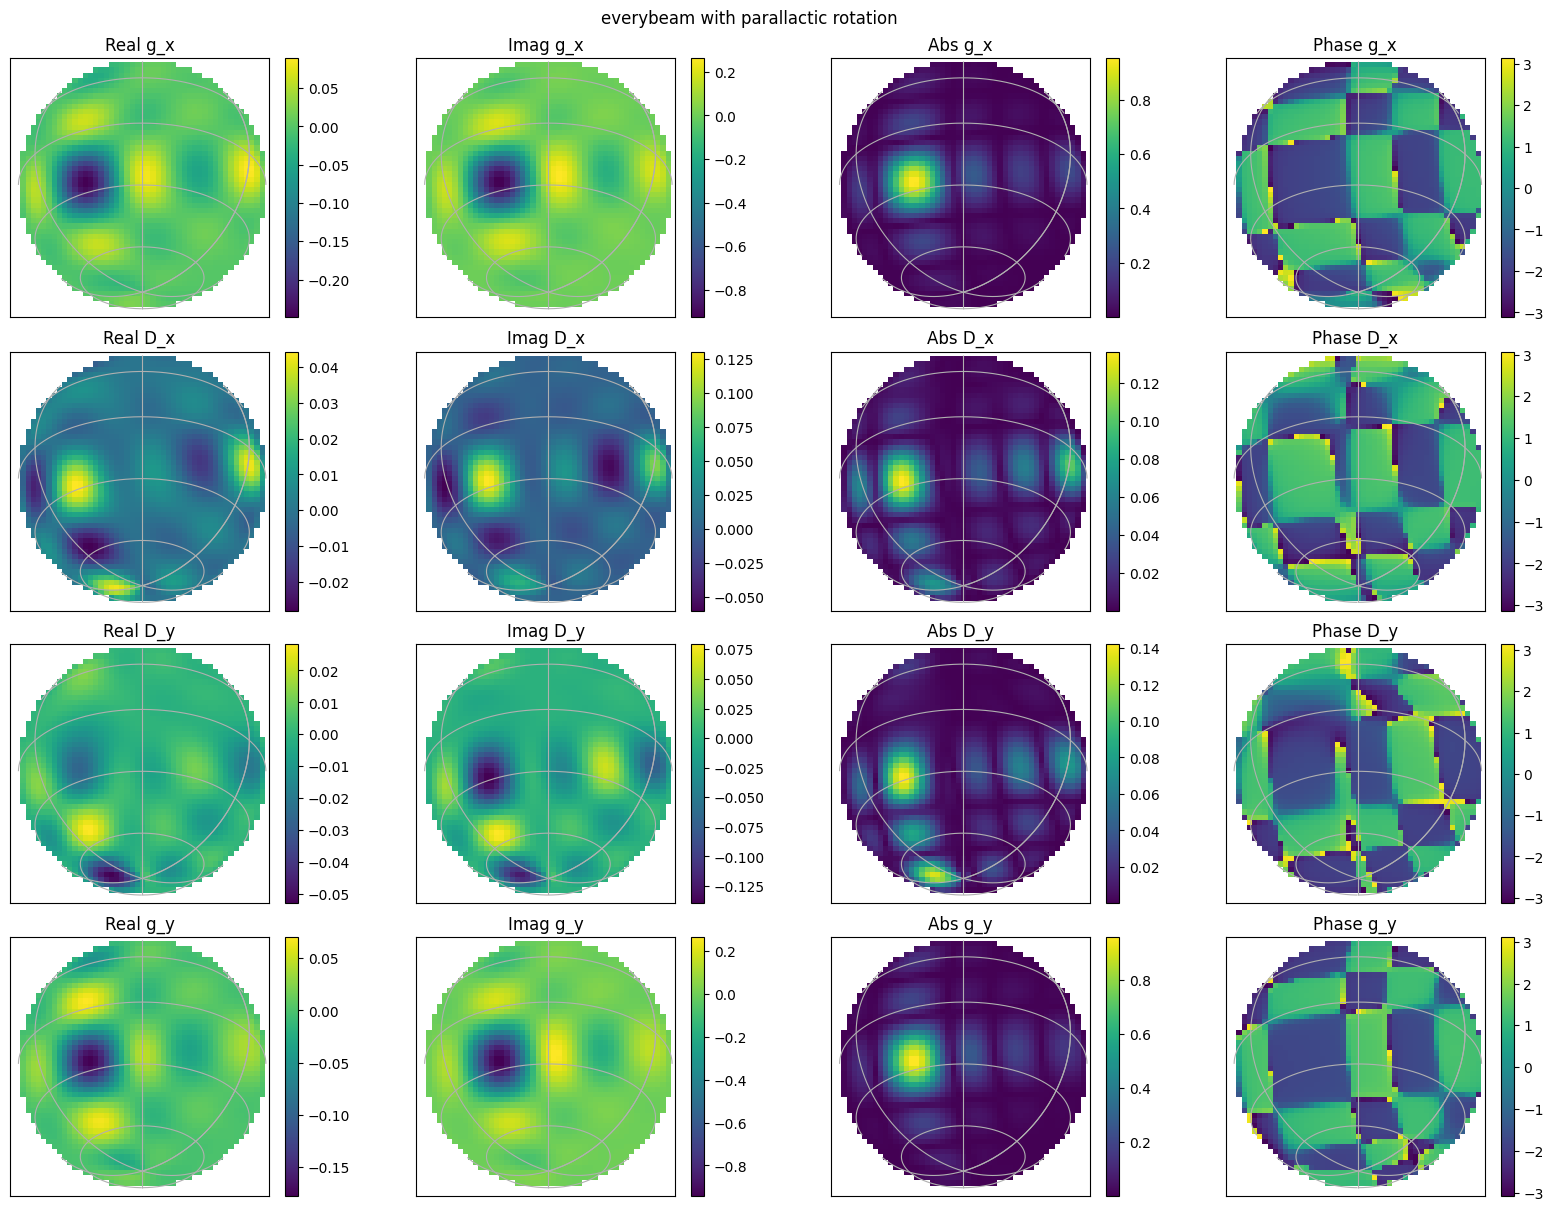

In [32]:
beam_ind = 0

for time_ind in range(len(all_times)):
    for freq_ind in range(len(all_freqs)):
        this_gx = all_jones[beam_ind, time_ind, freq_ind, :, 0, 0]
        this_Dx = all_jones[beam_ind, time_ind, freq_ind, :, 0, 1]
        this_Dy = all_jones[beam_ind, time_ind, freq_ind, :, 1, 0]
        this_gy = all_jones[beam_ind, time_ind, freq_ind, :, 1, 1]

        this_gx.shape = (nside, nside)
        this_Dx.shape = (nside, nside)
        this_Dy.shape = (nside, nside)
        this_gy.shape = (nside, nside)

        plot_jones_on_sky(this_gx, this_Dx, this_Dy, this_gy, wcs, title="everybeam with parallactic rotation")

Double check what it should look like using `hyperdrive`, where we can explicitly put the delays that we want in.

/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:18110: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)


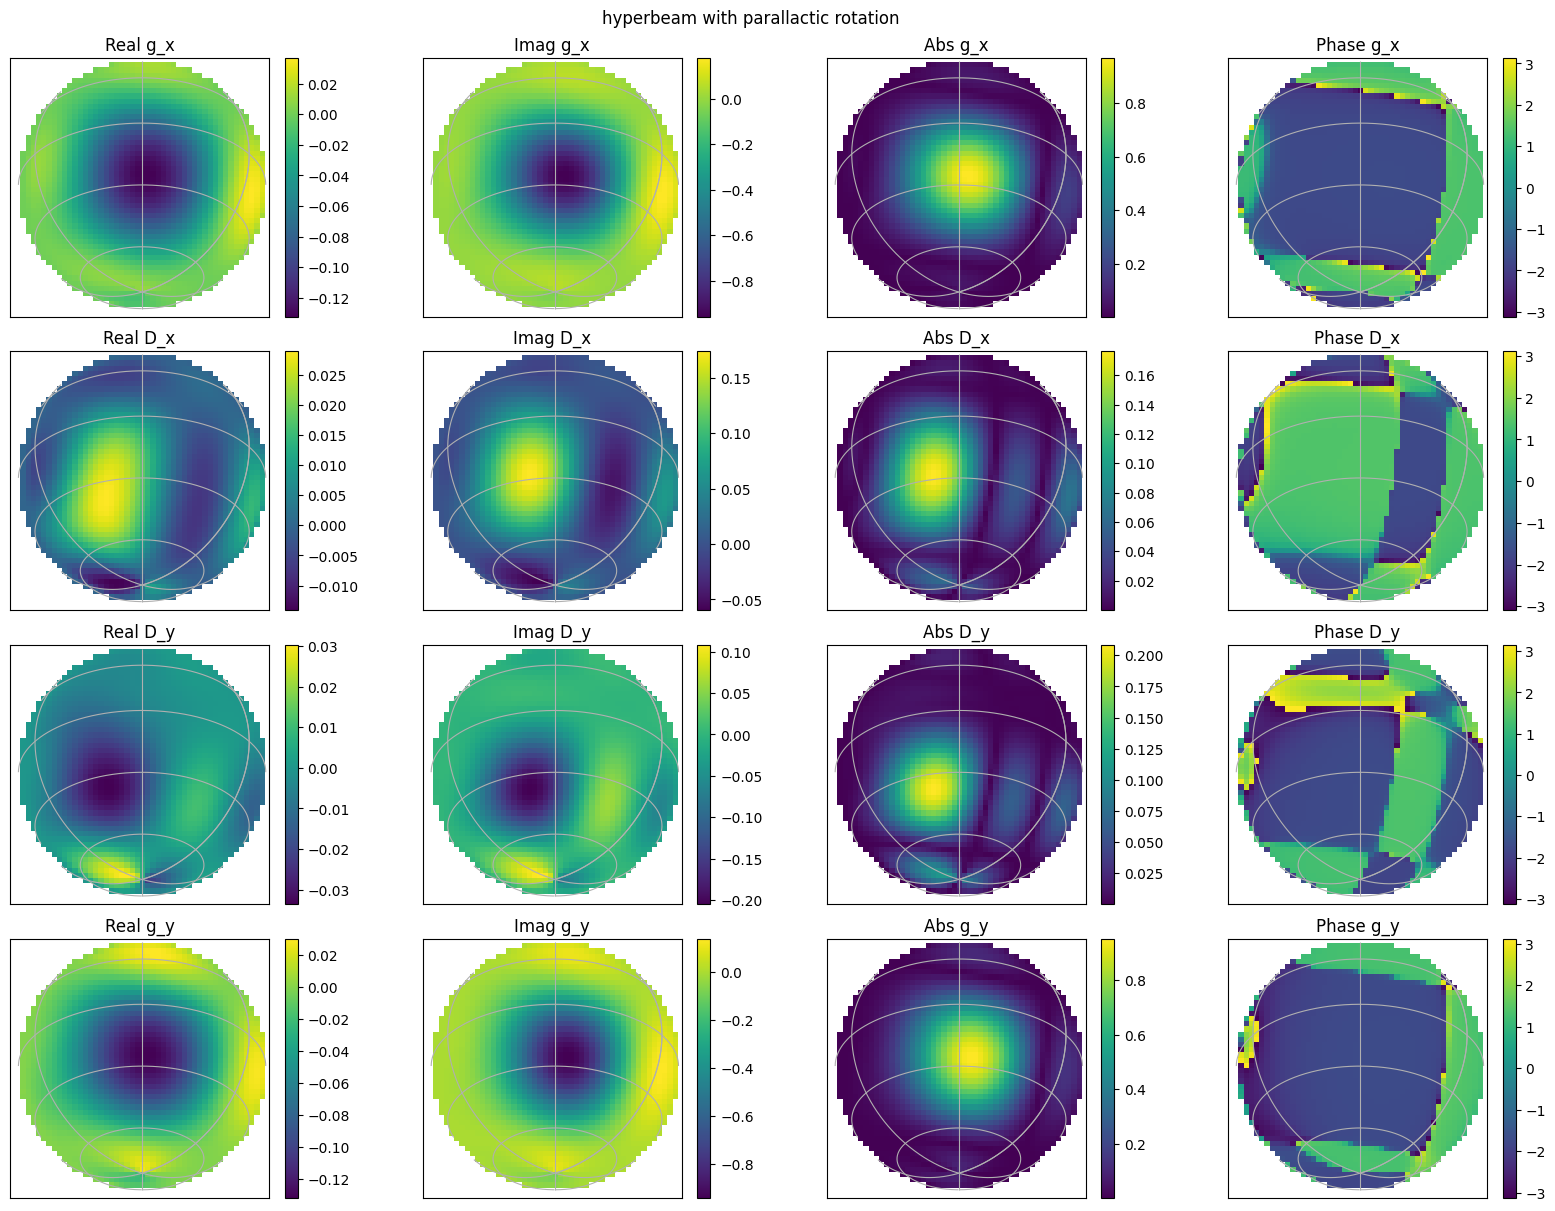

/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:18110: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)


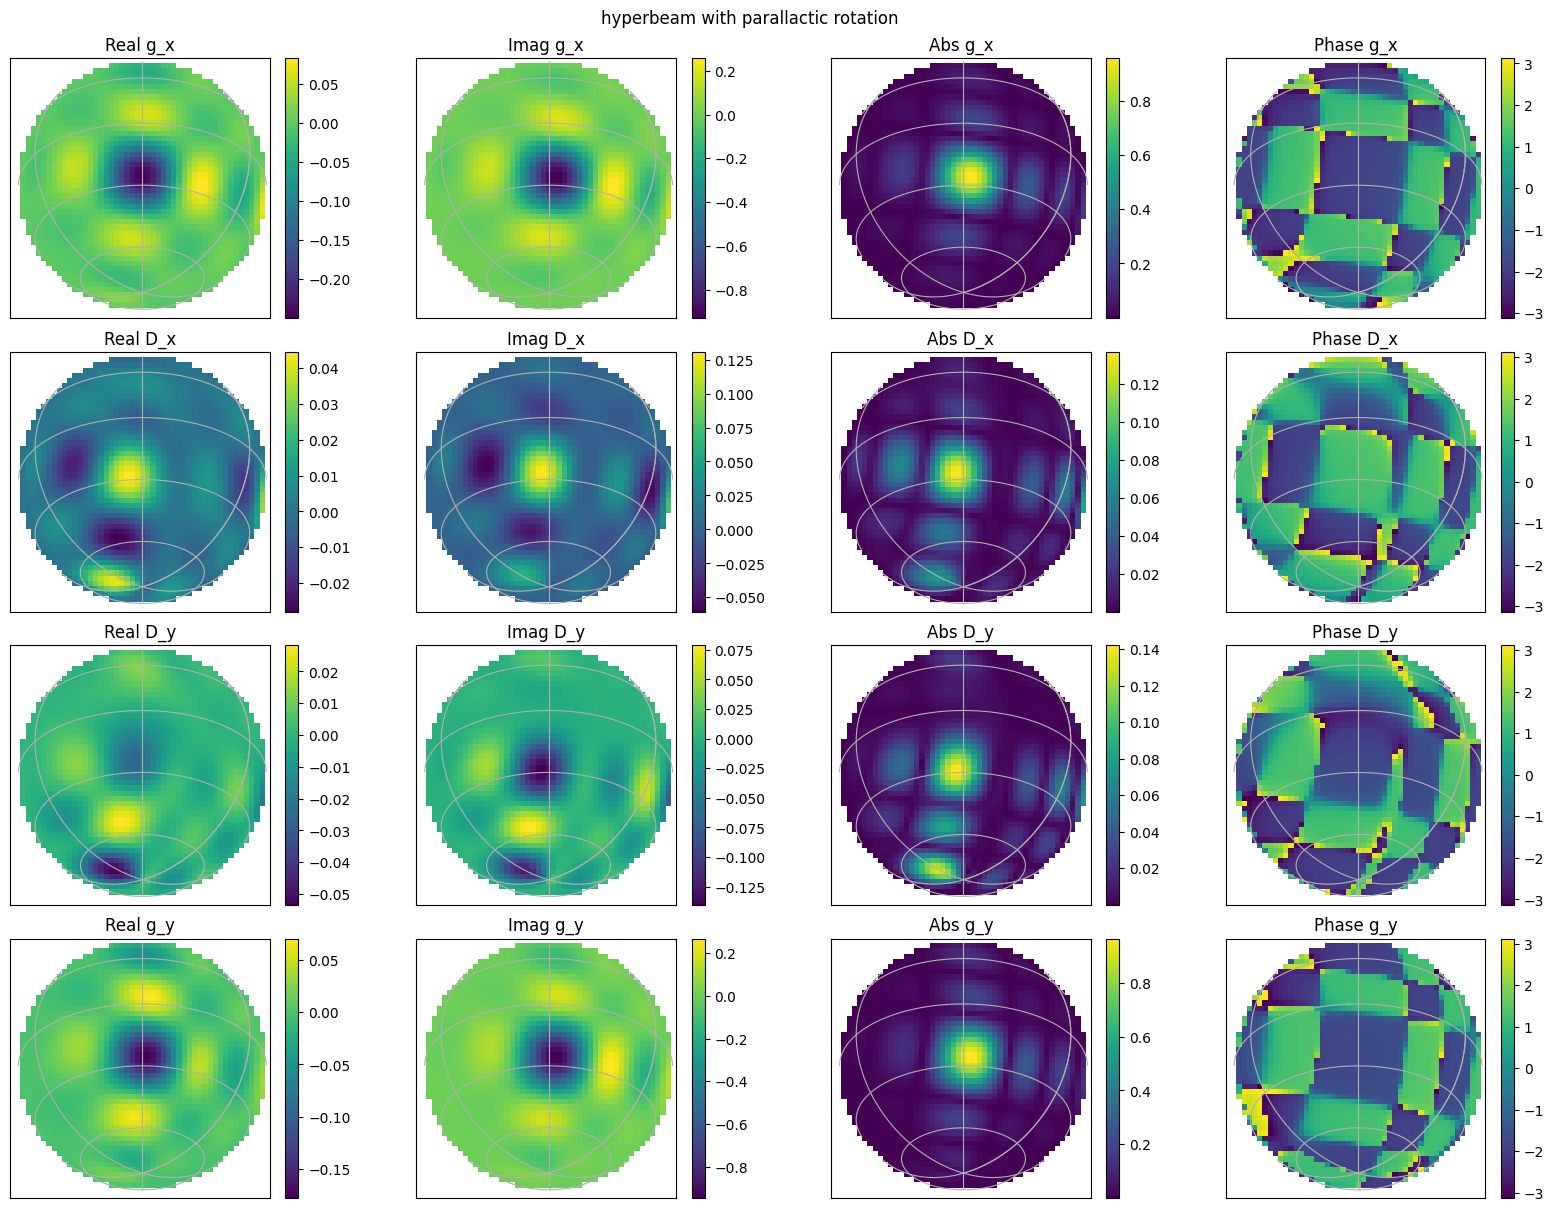

/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:18110: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)


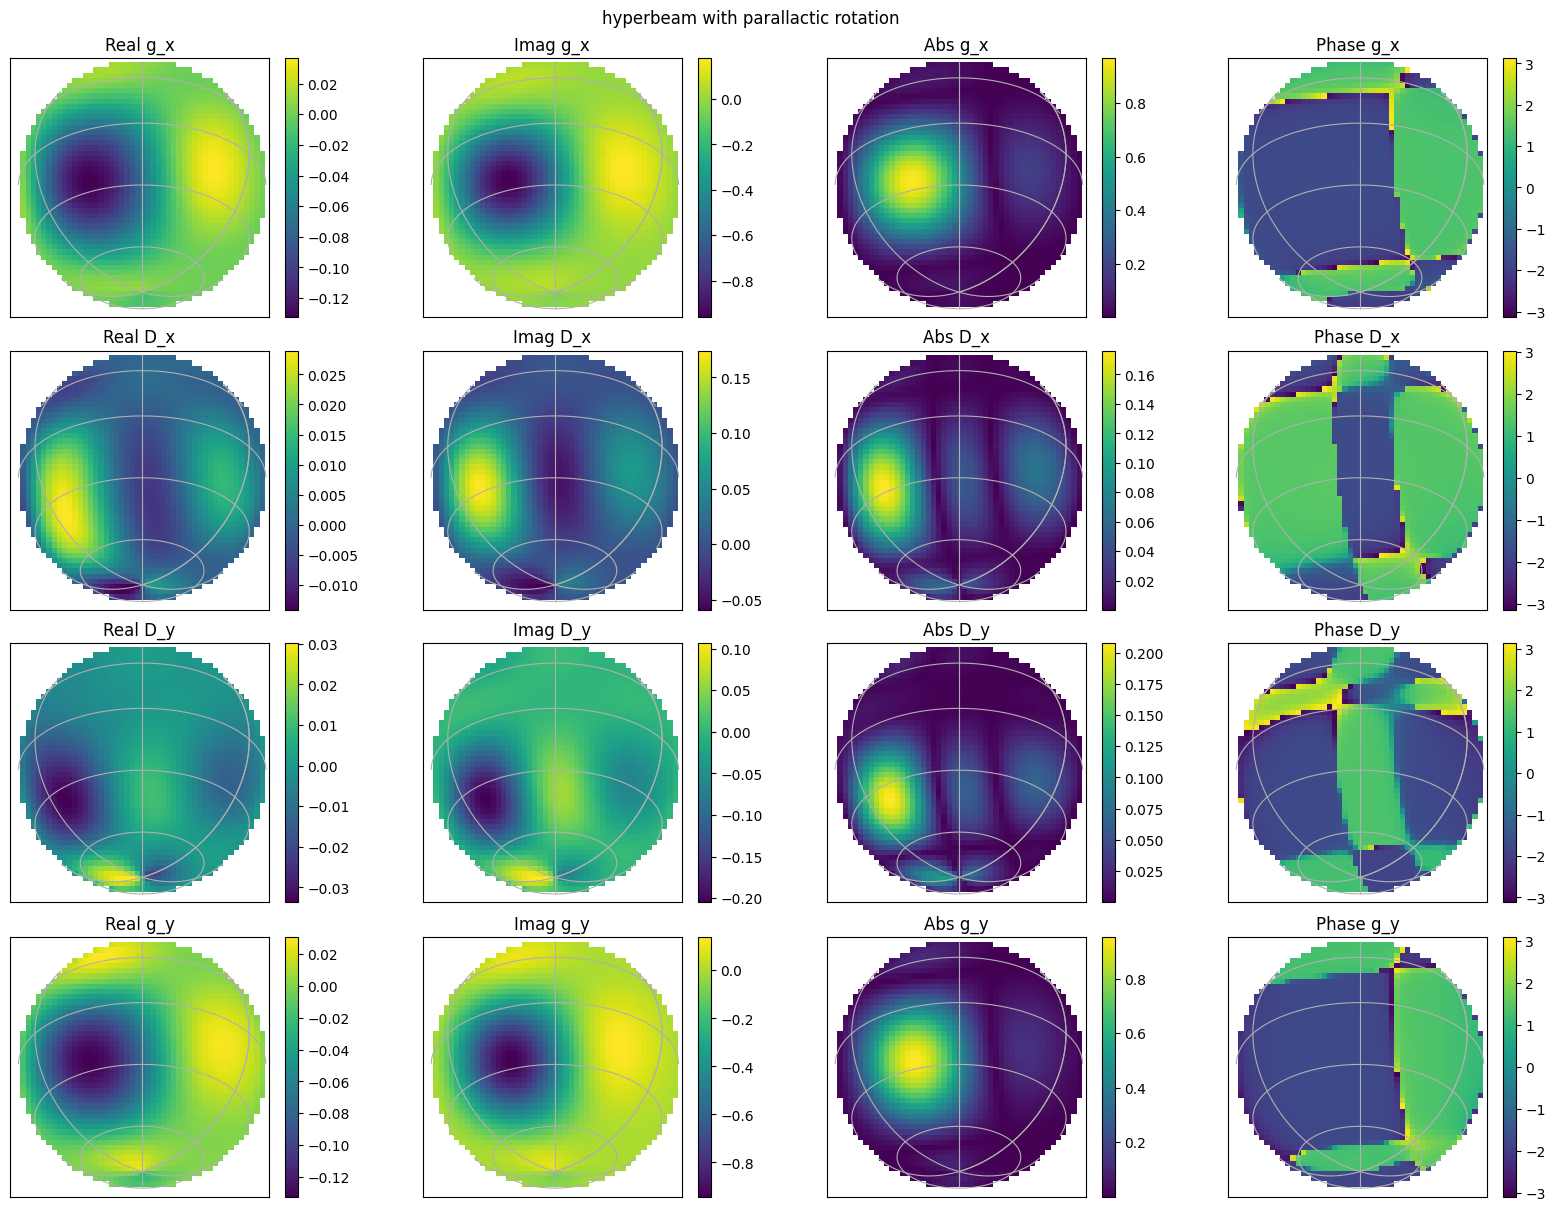

/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:18110: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)


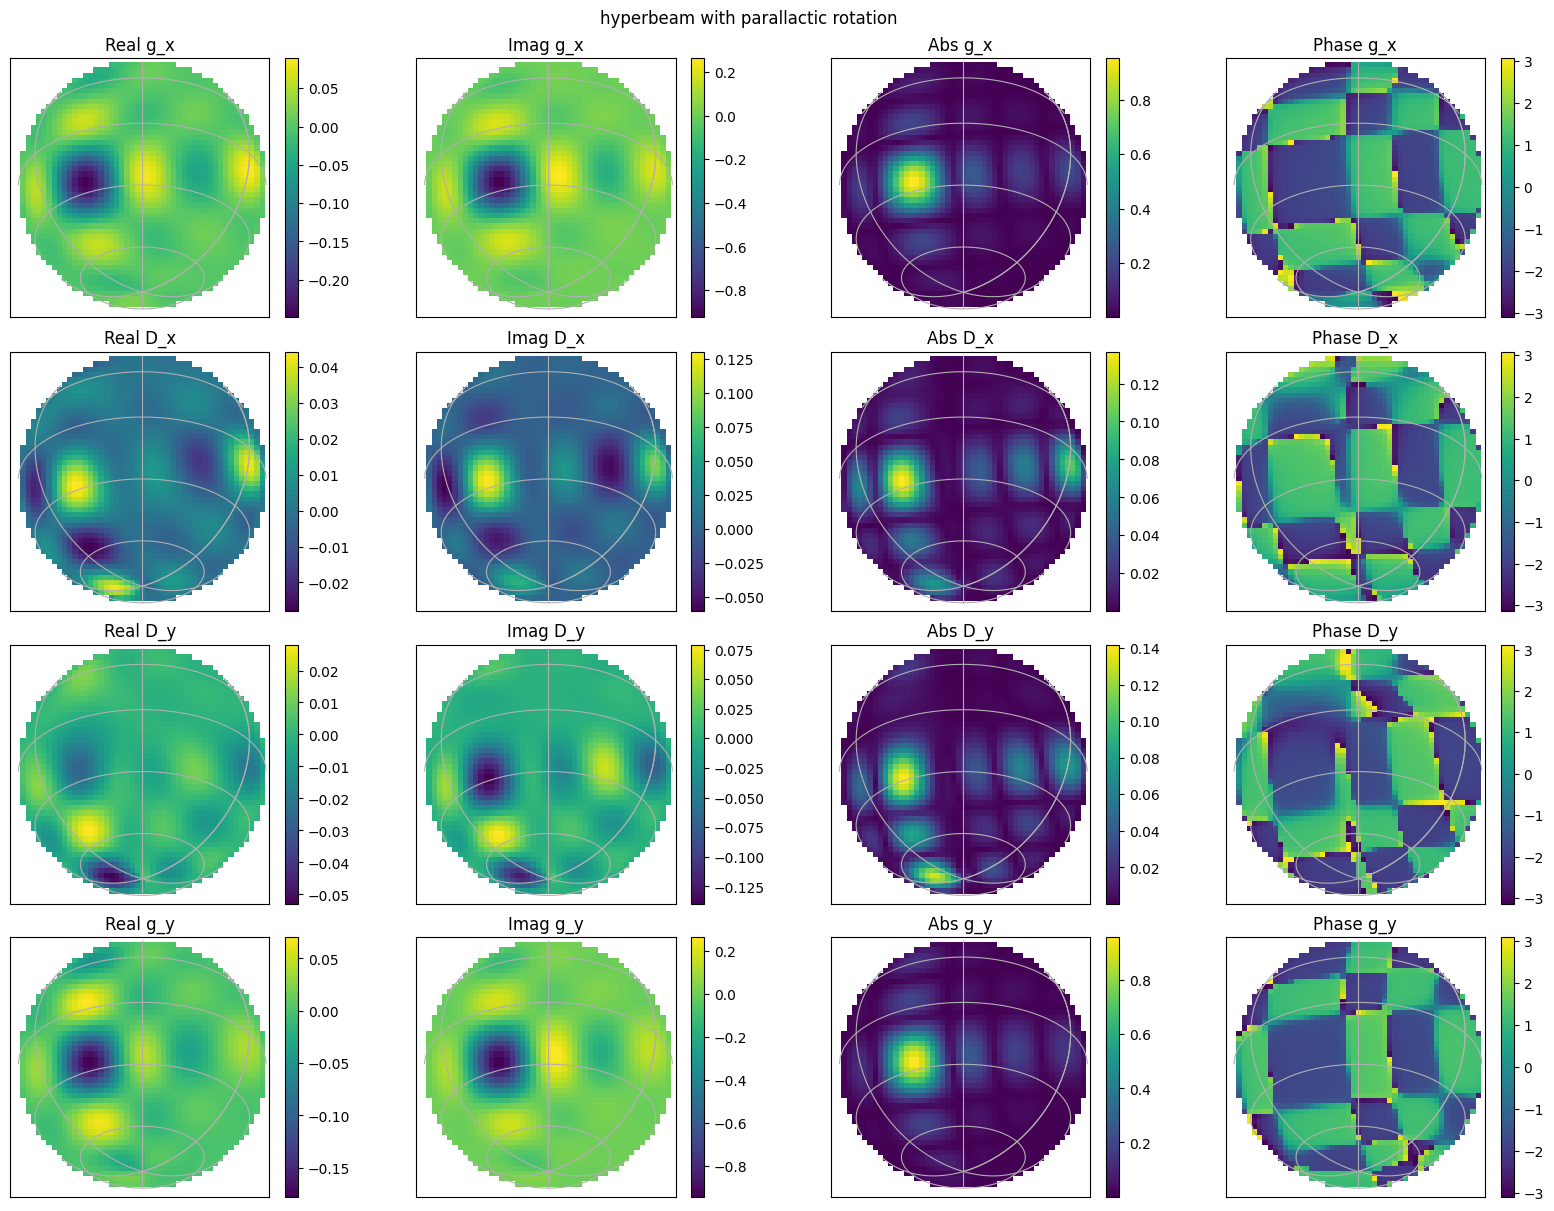

In [33]:
##use this erfa function to convert to azimuth and elevation
##were using degrees, but erfa uses rads, so convert here

for this_time in all_times:
    for freq in all_freqs:

        has = np.radians(this_time.sidereal_time('mean').value*15.0) - ras

        az_grid, els = erfa.hd2ae(has, decs, np.radians(MWA_LAT))

        za_grid = np.pi/2 - els

        beam = mwa_hyperbeam.FEEBeam()

        parallactic_rotation = True
        delays = [0,2,4,6,0,2,4,6,0,2,4,6,0,2,4,6]

        jones = beam.calc_jones_array(az_grid, za_grid, freq, delays, [1]*16, True, np.radians(MWA_LAT), parallactic_rotation)

        all_gx = jones[:,0]
        all_Dx = jones[:,1]
        all_Dy = jones[:,2]
        all_gy = jones[:,3]

        all_gx.shape = (nside, nside)
        all_Dx.shape = (nside, nside)
        all_Dy.shape = (nside, nside)
        all_gy.shape = (nside, nside)

        plot_jones_on_sky(all_gx, all_Dx, all_Dy, all_gy, wcs, title="hyperbeam with parallactic rotation")

## Profiling the code

Here we'll profile the code to see where the bottlenecks are. We'll use the `line_profiler` module.

Now make a sky model with an array of ra, decs so we can check the profiled outputs make sense, and also that the MWA beam is manifesting correctly. We'll run `WODEN` on the command line, setting `LINE_PROFILE=1` to ensure the `main` funciton gets profiled. We'll also add the `--profile` flag to `run_woden.py`. This is because `WODEN` run mulitple threads to speed up `EveryBeam` calls, and profilers struggle with threading. Internal to `WODEN`, we'll launch the `line_profiler` for every sky model thread, meaning we dump a bunch of reports.

Right, make the sky model here.

In [54]:
nside=15
radec_reso = 30/nside

ra0 = 0
dec0=-26.7

header, wcs = create_WCS(ra0, dec0, nside, radec_reso)
x_mesh, y_mesh = np.meshgrid(np.arange(nside), np.arange(nside))
ras, decs = wcs.all_pix2world(x_mesh, y_mesh, 0)

ras = ras.flatten()
decs = decs.flatten()

num_comps = len(ras)

c_ids = Column(data=np.array(['source']*num_comps), name='UNQ_SOURCE_ID', dtype='|S20')
c_names = Column(data=np.array([f'source_C{i:04d}' for i in range(num_comps)]), name='NAME', dtype='|S20')

##Component position
c_ras = Column(data=ras, name='RA')
c_decs = Column(data=decs, name='DEC')

##This says we have a point source
c_comp_types = Column(data=np.array(['P']*num_comps, dtype='|S1'), name="COMP_TYPE", dtype='|S1')
##This says we have a Stokes I power-law SED
c_mod_types = Column(data=np.array(['pl']*num_comps, dtype='|S3'), name="MOD_TYPE", dtype='|S3')

##Set everything as a flat spectrum 1 Jy stokes I source. That way we can image it and see the beam pattern
c_stokes_I_ref = Column(data=np.ones(num_comps), name='NORM_COMP_PL')
c_stokes_I_SI = Column(data=np.zeros(num_comps), name='ALPHA_PL')


cols = [c_ids, c_names, c_ras, c_decs, c_comp_types, c_mod_types, c_stokes_I_ref, c_stokes_I_SI]

main_table = Table(cols)

profile_cat = 'profiling_source.fits'

main_table.write(profile_cat, format='fits', overwrite=True)

Now make a `WODEN` command to profile, and launch it.

In [56]:
ra0=0.0
dec0=-26.7
date="2024-07-21T20:13:00"
profile_cat="profiling_source.fits"
primary_beam="everybeam_MWA"
num_times=5
num_freq_chans=10
low_freq=160e+6
ms_path="MWA-single-timeslot.ms"
uvfits_name="profile_run_woden"
freq_reso=80e+3

command = "LINE_PROFILE=1 run_woden.py "

command += f'--ra0={ra0} '
command += f'--dec0={dec0} '
command += f'--date={date} '
command += f'--output_uvfits_prepend={uvfits_name} '
command += f'--primary_beam={primary_beam} '
command += f'--beam_ms_path={ms_path} '
command += f'--freq_res={freq_reso} '
command += f'--band_nums=1 '
command += f'--num_time_steps={num_times} '
command += f'--IAU_order '
command += f'--station_id=0 '
command += f'--cat_filename={profile_cat} '
command += f'--lowest_channel_freq={low_freq} '
command += f'--num_freq_channels={num_freq_chans} '
command += f'--time_res=2 '
command += f'--num_threads=8 '
command += f'--profile '

##Delete previous results before running
call('rm *.lprof', shell=True)
call(command, shell=True)


/home/jline/software/anaconda3/envs/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.3.0')


Successful readonly open of default-locked table MWA-single-timeslot.ms/ANTENNA: 8 columns, 128 rows
You are using WODEN commit: No git describe nor __version__ avaible
LOADING IN /home/jline/software/WODEN_dev/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00000deg -26.70000deg
Obs epoch initial LST was 0.0087300922 deg
Setting initial J2000 LST to 359.6931723607 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 225 components
After cropping there are 225 components
From Set 0 thread num 0 reading 29 points, 0 gauss, 0 shape, 0 shape coeffs using thread id 0
From Set 0 thread num 2 reading 29 points, 0 gauss, 0 shape, 0 shape coeffs using thread id 2From Set 0 thread num 1 reading 29 poin

0

OK, the `main` function will be profiled with the results written to `profile_output.txt`. We'll also get a bunch of `*.lprof` files for each of the sky model / beam calculation threads, which we can read in with `line_profiler` to see what's going on. First up, let's look at some specific lines from `profile_output.txt`. The part below shows where the sky model/beam calculation code, as well as the GPU code, is run:

```
Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
353         1      27432.0  27432.0      0.0              gpu_executor = concurrent.futures.ThreadPoolExecutor(max_workers=1)
354         1        341.0    341.0      0.0              gpu_calc = None  # To store the future of the calculation thread
355                                           
356                                                       # Loop through multiple rounds of data reading and calculation
357         2       2485.0   1242.5      0.0              for round_num in range(num_rounds):
358        25   49810705.0    2e+06      0.0                  future_data = [executor.submit(read_skymodel_thread, i + round_num * num_threads,
359         8       6514.0    814.2      0.0                                                 num_threads, chunked_skymodel_map_sets,
360         8       5559.0    694.9      0.0                                                 lsts, latitudes,
361         8       5080.0    635.0      0.0                                                 args,
362         8      15790.0   1973.8      0.0                                                 woden_settings.beamtype,
363         8       6105.0    763.1      0.0                                                 main_table, shape_table,
364         8       1743.0    217.9      0.0                                                 v_table, q_table, u_table, p_table)
365         9       2786.0    309.6      0.0                                 for i in range(num_threads)]
366                                                           
367         1       6653.0   6653.0      0.0                  all_loaded_python_sources = []
368         1        301.0    301.0      0.0                  all_loaded_sources_orders = []
369         9        3e+11    3e+10     98.5                  for future in concurrent.futures.as_completed(future_data):
370         8     171885.0  21485.6      0.0                      python_sources, order = future.result()
371         8      10681.0   1335.1      0.0                      all_loaded_python_sources.append(python_sources)
372         8       9549.0   1193.6      0.0                      all_loaded_sources_orders.append(order)
373                                                               
374                                                           # Wait for previous calculation to complete (if there was one)
375         1        621.0    621.0      0.0                  if gpu_calc is not None:
376                                                               meh = gpu_calc.result()
377                                           
378         2    5909958.0    3e+06      0.0                  gpu_calc = gpu_executor.submit(woden_thread,
379         1        210.0    210.0      0.0                                                 all_loaded_python_sources,
380         1        161.0    161.0      0.0                                                 all_loaded_sources_orders,
381         1        331.0    331.0      0.0                                                 round_num,
382         1       4869.0   4869.0      0.0                                                 run_woden, woden_settings,
383         1       3075.0   3075.0      0.0                                                 visi_set_array, array_layout, 
384         1       1433.0   1433.0      0.0                                                 woden_struct_classes, sbf,
385         1       3566.0   3566.0      0.0                                                 woden_settings.beamtype,
386         1       3937.0   3937.0      0.0                                                 args.precision)
387                                                           
388                                                       # # Wait for the final calculation to complete
389         1        291.0    291.0      0.0              if gpu_calc is not None:
390         1 1026352569.0    1e+09      0.4                  meh = gpu_calc.result()
281.44 seconds - /home/jline/software/WODEN_dev/scripts/run_woden.py:242 - main
```

Specifically, these lines:
```
    Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
   369         9        3e+11    3e+10     98.5                  for future in concurrent.futures.as_completed(future_data):
   390         1 1026352569.0    1e+09      0.4                  meh = gpu_calc.result()
```
show that 98.5% of the entire time is spent gathering results from sky model/beam calculation code, and 0.4% is doing GPU calculations.

However, this doesn't tell us whether the sky model reading is slow, or  the `EveryBeam` code calls are. For that, we have to look at the `line_profile_*.lprof` files, which are output by each thread. We'll look at the entirety of the first one here:

In [58]:
from glob import glob
from line_profiler.line_profiler import load_stats, show_text
import line_profiler

files = glob("line_profile_*.lprof")

stats = load_stats(files[0])
show_text(stats.timings, stats.unit)

Timer unit: 1e-09 s

Total time: 276.51 s
File: /home/jline/software/WODEN_dev/wodenpy/primary_beam/use_everybeam.py
Function: run_everybeam at line 221

Line #      Hits         Time  Per Hit   % Time  Line Contents
   221                                           def run_everybeam(ras : np.ndarray, decs : np.ndarray,
   222                                                             beam_ra0 : float, beam_dec0 : float,
   223                                                             j2000_latitudes : np.ndarray, j2000_lsts : np.ndarray,
   224                                                             current_latitude : float, current_longitude : float,
   225                                                             times : np.ndarray, freqs : np.ndarray,
   226                                                             telescope: eb.Telescope,  # type: ignore
   227                                                             station_ids : np.ndarray,
   228                   

By adding the `--profile` flag to `run_woden.py`, I've set things up to profile the following functions:

- `read_fits_skymodel_chunks` which reads the sky model and calculates the beam
- `calc_everybeam_for_components` which calculates the EveryBeam responses for all components in a sky model chunk. Is called by `calc_everybeam_for_components`.
- `run_everybeam`, which calls `EveryBeam` for a given set of RA/Decs, frequencies, times, can normalise, and parallactic rotate if needed.


OK, the lines selected from above tells us that the function `read_fits_skymodel_chunks` spends 100.0% of its time calling `calc_everybeam_for_components`, which in turn spends 100% of its time calling `run_everybeam`. The `run_everybeam` function spends 99.8% of its time getting the telescope station response, which is the `EveryBeam` call. 
``` 
1333         2        3e+11    1e+11    100.0                  calc_everybeam_for_components(beam_ra0, 

1174         2        3e+11    1e+11    100.0      all_jones = run_everybeam(ras, decs, beam_ra0, beam_dec0,

344      2900        3e+11    1e+08     99.8                              response = telescope.station_response
```
In short, we've whittled all the Python calls down to `EveryBeam`, so that's where the bottleneck is. Just to make sure every thread behaves the same, we can look for the specific `EveryBeam` calls in the other `line_profile_*.lprof` files.

In [59]:
import io
from contextlib import redirect_stdout

##We'll capture the line_profiler output, which normally goes to stdout,
##so we can just search for the line we want.
with io.StringIO() as buf, redirect_stdout(buf):
    
    for file in files:
    
        stats = load_stats(file)
        show_text(stats.timings, stats.unit)
    
    output = buf.getvalue()
    
    
output = ''.join(output)
lines = output.split('\n')

for line in lines:
    ##Just be lazy and find the line number from the `run_everybeam` function
    if line[:6] ==  "   344":
        print(line)

   344      2900        3e+11    1e+08     99.8                              response = telescope.station_response(time_mjd_secs, station_id, freq,
   344      2200        2e+11    1e+08     99.8                              response = telescope.station_response(time_mjd_secs, station_id, freq,
   344      2900        3e+11    1e+08     99.8                              response = telescope.station_response(time_mjd_secs, station_id, freq,
   344      2900        3e+11    9e+07     99.8                              response = telescope.station_response(time_mjd_secs, station_id, freq,
   344      2900        3e+11    9e+07     99.8                              response = telescope.station_response(time_mjd_secs, station_id, freq,
   344      2900        3e+11    9e+07     99.8                              response = telescope.station_response(time_mjd_secs, station_id, freq,
   344      2900        3e+11    1e+08     99.8                              response = telescope.station_respon

So indeed all threads spend most of their time doing EveryBeam calls.

Now let's check out profiling outputs look correct:

In [39]:
cmd = "woden_uv2ms.py "
cmd += "  --uvfits_prepend=profile_run_woden_band "
cmd += "  --band_nums=1  "

call(cmd, shell=True)

cmd = "wsclean -name profile_run_woden -size 2048 2048 -niter 10000 "
cmd += "  -auto-threshold 0.5 -auto-mask 3 "
cmd += "  -pol I -multiscale -weight briggs 0 -scale 0.03 -j 12 -mgain 0.85 "
cmd += "  -no-update-model-required "
cmd += "  profile_run_woden_band*.ms "

##My local WSClean installation is borked, so I have to run this on the command line.
##You should be able to run via `call(cmd, shell=True)` below
print(cmd)
# call(cmd, shell=True)

/home/jline/software/anaconda3/envs/woden_dev/bin/woden_uv2ms.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.3.0')
The telescope frame is set to '????', which generally indicates ignorance. Defaulting the frame to 'itrs', but this may lead to other warnings or errors.
Writing in the MS file that the units of the data are uncalib, although some CASA process will ignore this and assume the units are all in Jy (or may not know how to handle data in these units).


wsclean -name profile_run_woden -size 2048 2048 -niter 10000   -auto-threshold 0.5 -auto-mask 3   -pol I -multiscale -weight briggs 0 -scale 0.03 -j 12 -mgain 0.85   -no-update-model-required   profile_run_woden_band*.ms 


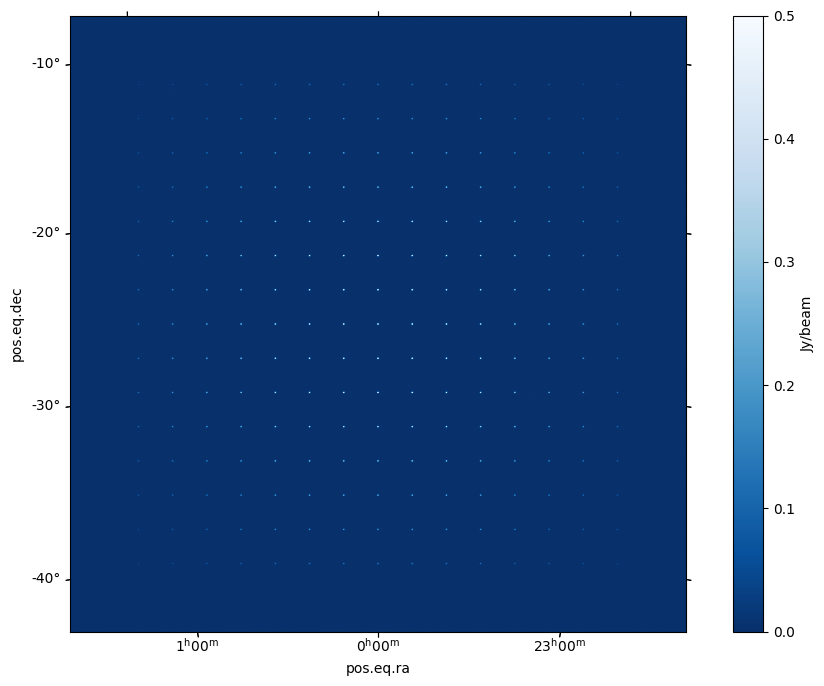

In [66]:

with fits.open('profile_run_woden-image.fits') as hdu:
    image = np.squeeze(hdu[0].data)
    wcs = WCS(hdu[0].header).celestial
    
fig, axs = plt.subplots(1, 1, figsize=(12, 8), subplot_kw={'projection': wcs})

im = axs.imshow(image, origin='lower', cmap='Blues_r', vmin=0, vmax=0.5)
plt.colorbar(im, ax=axs, label='Jy/beam')

half_width = 600

axs.set_xlim(1024-half_width, 1024+half_width)
axs.set_ylim(1024-half_width, 1024+half_width)

plt.show()

Looks like the point sources toward the edge are being tapered off ala a good old MWA primary beam lobe, so huzzah.

## Interpolated beam
Can we use the interpolated Daniel Ung `.h5` file for highband? Let's try it.

In [41]:

from astropy.table import Column, Table
import numpy as np
import os

sing_ra = 15.0
sing_dec = -40.0

ras = [sing_ra]
decs = [sing_dec]

num_comps = len(ras)

c_ids = Column(data=np.array(['source']*num_comps), name='UNQ_SOURCE_ID', dtype='|S20')
c_names = Column(data=np.array([f'source_C{i:04d}' for i in range(num_comps)]), name='NAME', dtype='|S20')

##Component position
c_ras = Column(data=ras, name='RA')
c_decs = Column(data=decs, name='DEC')

##This says we have a point source
c_comp_types = Column(data=np.array(['P']*num_comps, dtype='|S1'), name="COMP_TYPE", dtype='|S1')
##This says we have a Stokes I power-law SED
c_mod_types = Column(data=np.array(['pl']*num_comps, dtype='|S3'), name="MOD_TYPE", dtype='|S3')

##Set everything as a flat spectrum 1 Jy stokes I source. That way we can image it and see the beam pattern
c_stokes_I_ref = Column(data=np.ones(num_comps), name='NORM_COMP_PL')
c_stokes_I_SI = Column(data=np.zeros(num_comps), name='ALPHA_PL')


cols = [c_ids, c_names, c_ras, c_decs, c_comp_types, c_mod_types, c_stokes_I_ref, c_stokes_I_SI]

main_table = Table(cols)

single_cat = 'single_point.fits'

main_table.write(single_cat, format='fits', overwrite=True)


ra0=0.0
dec0=-26.7
date="2024-07-21T20:13:00"
primary_beam="everybeam_MWA"
num_times=1
num_freq_chans=390
low_freq=167e+6
ms_path="MWA-single-timeslot.ms"
uvfits_name="interp_run_woden"
freq_reso=80e+3

args = []

interp_h5 = os.environ['MWA_FEE_HDF5_INTERP']

args.append(f'--ra0={sing_ra}')
args.append(f'--dec0={-sing_dec}')
args.append(f'--metafits_filename=1125949472_metafits.fits')
args.append(f'--output_uvfits_prepend={uvfits_name}')
args.append(f'--primary_beam={primary_beam}')
args.append(f'--beam_ms_path={ms_path}')
args.append(f'--freq_res={freq_reso}')
args.append(f'--band_nums=1')
args.append(f'--num_time_steps={num_times}')
args.append(f'--IAU_order')
args.append(f'--station_id=0')
args.append(f'--cat_filename={single_cat}')
args.append(f'--lowest_channel_freq={low_freq}')
args.append(f'--num_freq_channels={num_freq_chans}')
args.append(f'--time_res=2')
args.append(f'--num_threads=1')
args.append(f'--hdf5_beam_path={interp_h5}')

run_woden(args)

Successful readonly open of default-locked table MWA-single-timeslot.ms/ANTENNA: 8 columns, 128 rows
You are using WODEN commit: No git describe nor __version__ avaible
LOADING IN /home/jline/software/WODEN_dev/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 15.00000deg 40.00000deg
Obs epoch initial LST was 42.2620215148 deg
Setting initial J2000 LST to 42.0911874758 deg
Setting initial mjd to 57275.8224074073
After precession initial latitude of the array is -26.7665041369 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
From Set 0 thread num 0 reading 1 points, 0 gauss, 0 shape, 0 shape coeffs using thread id 0
Finshed thread 0 in 377.9 seconds
Sending set 0 to GPU
Set 0 has returned from the GPU after 1.3 seconds


In [42]:
coarse_h5 = os.environ['MWA_FEE_HDF5']

uvfits_name = 'coarse_run_woden'

args.append(f'--ra0={sing_ra}')
args.append(f'--dec0={-sing_dec}')
args.append(f'--metafits_filename=1125949472_metafits.fits')
args.append(f'--output_uvfits_prepend={uvfits_name}')
args.append(f'--primary_beam={primary_beam}')
args.append(f'--beam_ms_path={ms_path}')
args.append(f'--freq_res={freq_reso}')
args.append(f'--band_nums=1')
args.append(f'--num_time_steps={num_times}')
args.append(f'--IAU_order')
args.append(f'--station_id=0')
args.append(f'--cat_filename={single_cat}')
args.append(f'--lowest_channel_freq={low_freq}')
args.append(f'--num_freq_channels={num_freq_chans}')
args.append(f'--time_res=2')
args.append(f'--num_threads=1')
args.append(f'--hdf5_beam_path={coarse_h5}')

run_woden(args)

Successful readonly open of default-locked table MWA-single-timeslot.ms/ANTENNA: 8 columns, 128 rows
You are using WODEN commit: No git describe nor __version__ avaible
LOADING IN /home/jline/software/WODEN_dev/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 15.00000deg 40.00000deg
Obs epoch initial LST was 42.2620215148 deg
Setting initial J2000 LST to 42.0911874758 deg
Setting initial mjd to 57275.8224074073
After precession initial latitude of the array is -26.7665041369 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
From Set 0 thread num 0 reading 1 points, 0 gauss, 0 shape, 0 shape coeffs using thread id 0
Finshed thread 0 in 32.6 seconds
Sending set 0 to GPU
Set 0 has returned from the GPU after 0.8 seconds


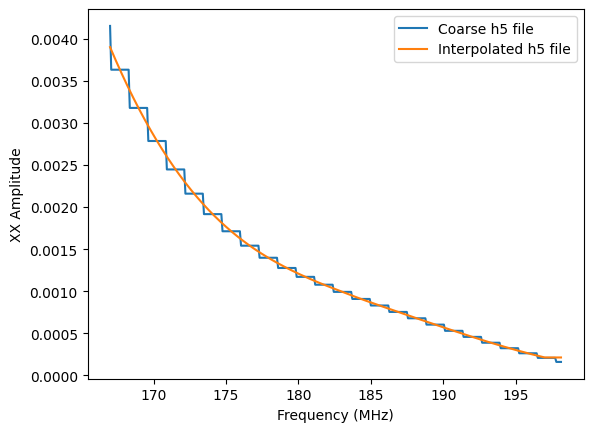

In [44]:
xx_interp, xy_interp, yx_interp, yy_interp = read_uvfits('interp_run_woden_band01.uvfits')
xx_coarse, xy_coarse, yx_coarse, yy_coarse = read_uvfits('coarse_run_woden_band01.uvfits')

freqs = np.arange(low_freq, low_freq + num_freq_chans*freq_reso, freq_reso)

xx_abs = np.abs(xx_coarse[0])
plt.plot(freqs/1e+6, xx_abs, label='Coarse h5 file')

xx_abs = np.abs(xx_interp[0])
plt.plot(freqs/1e+6, xx_abs, label='Interpolated h5 file')
plt.xlabel('Frequency (MHz)')
plt.ylabel('XX Amplitude')
plt.legend()
plt.show()




Yup, seems like we can indeed. It is over 10x slower however. I'm calling `EveryBeam` the exact same number of times, as I already call it for every frequency. Maybe `EveryBeam` is smart enough to cache frequency outputs?